# **Column Descriptions**

- `PassengerId` - уникальный идентификатор для каждого пассажира. Каждый идентификатор принимает форму gggg_pp, где gggg указывает группу, с которой путешествует пассажир, а pp — его номер в группе. Люди в группе часто являются членами семьи, но не всегда.
- `HomePlanet` - планета, с которой вылетел пассажир, обычно планета его постоянного проживания.
- `CryoSleep` – указывает, выбрал ли пассажир режим анабиоза на время путешествия. Пассажиры, находящиеся в криосонном состоянии, находятся в своих каютах.
- `Cabin` - Номер каюты, в которой находится пассажир. Принимает форму палуба/число/сторона, где сторона может быть либо P для левого борта, либо S для правого борта.
- `Пункт назначения` - планета, на которую будет высаживаться пассажир.
- `Возраст` - Возраст пассажира.
- `VIP` - оплатил ли пассажир специальное VIP-обслуживание во время рейса.
- `RoomService`, FoodCourt, ShoppingMall, Spa, VRDeck - Сумма, которую пассажир выставил в счет за каждое из многочисленных роскошных удобств космического корабля Титаник.
- `Name` - Имя и фамилия пассажира.
- `Транспортировано` - Был ли пассажир перенесен в другое измерение. Это цель, столбец, который вы пытаетесь предсказать.

# 1. **Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')
import time
import optuna

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, auc, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 2. **EDA**

In [2]:
train=pd.read_csv('/spaceship-titanic/train.csv')
test=pd.read_csv('/spaceship-titanic/test.csv')

In [3]:
train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [4]:
test.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez

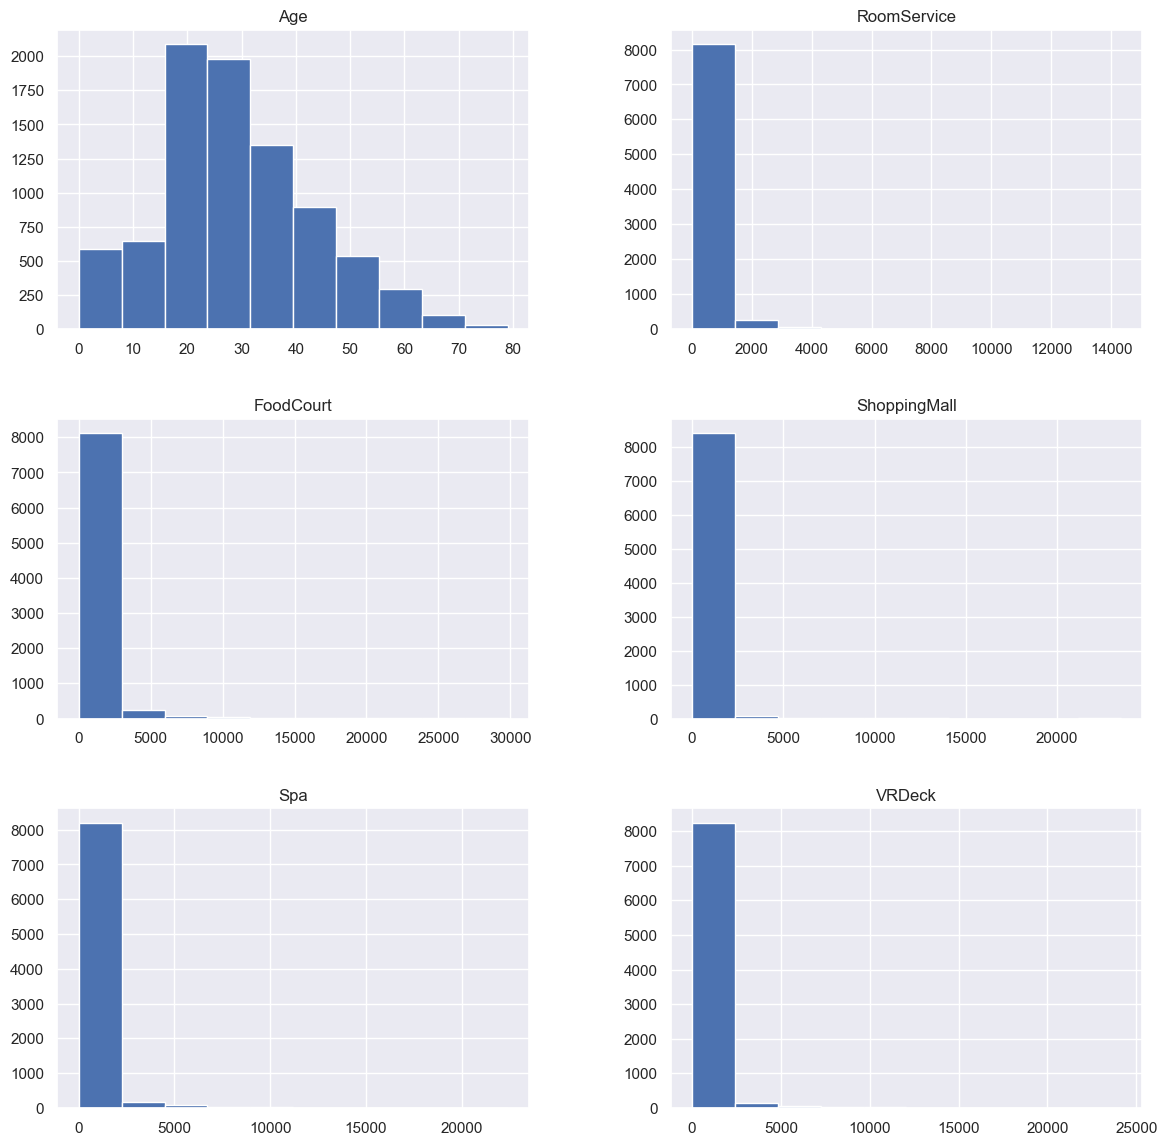

In [5]:
sns.set()

train.hist(figsize=(14,14));

<AxesSubplot: >

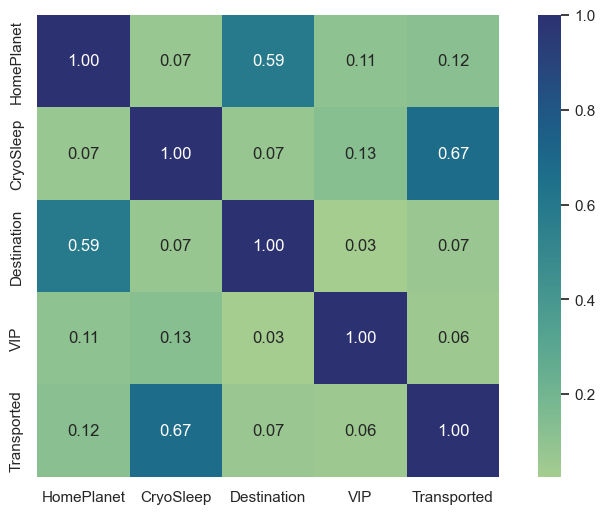

In [6]:
plt.subplots(figsize=(10, 6))
sns.heatmap(
    train[['HomePlanet', 'CryoSleep', 'Destination',
           'VIP', 'Transported']].phik_matrix(),
    cmap="crest",
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
)

Phik корреляция показывает некую зависимость между CryoSleep и целевым признаком Transported. 

<AxesSubplot: >

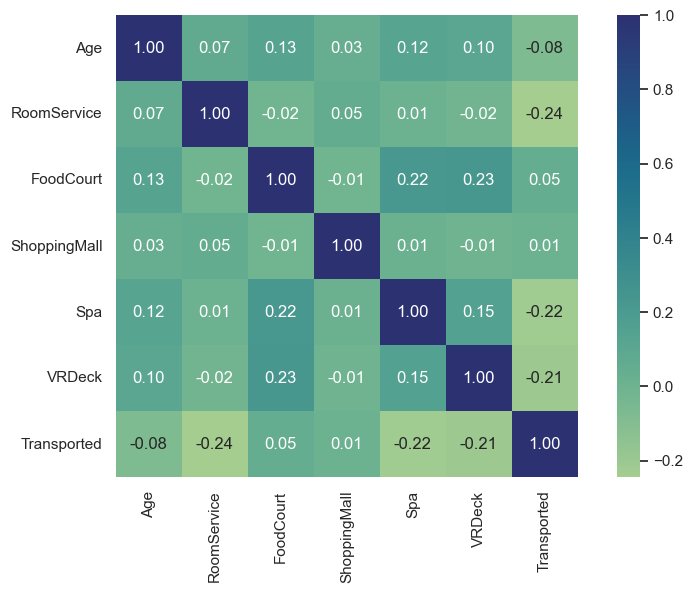

In [7]:
plt.subplots(figsize=(10, 6))
sns.heatmap(
    train.corr(method='pearson'),
    cmap="crest",
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
)

В числовых признаках никаких зависимостей не обнаружено.

Посмотрим на соотношение классов.

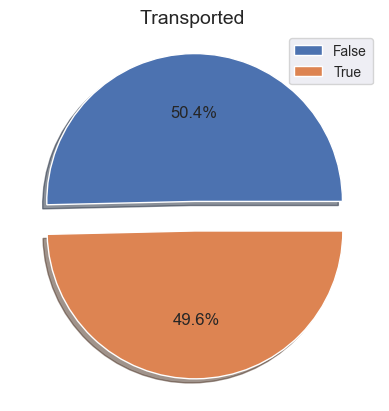

In [8]:
plt.pie(
    train.Transported.value_counts(),
    shadow=True,
    explode=[.1, .1],
    autopct='%.1f%%'
)

plt.title('Transported ', size=14)
plt.legend(['False', 'True'], fontsize=10)
plt.show()

*Вывод:*

Класссы в нашей обучающей выборке оказались сбалансированны, что очень хорошо.

Посмотрим на соотношение пассажиров в категориальных признаках.

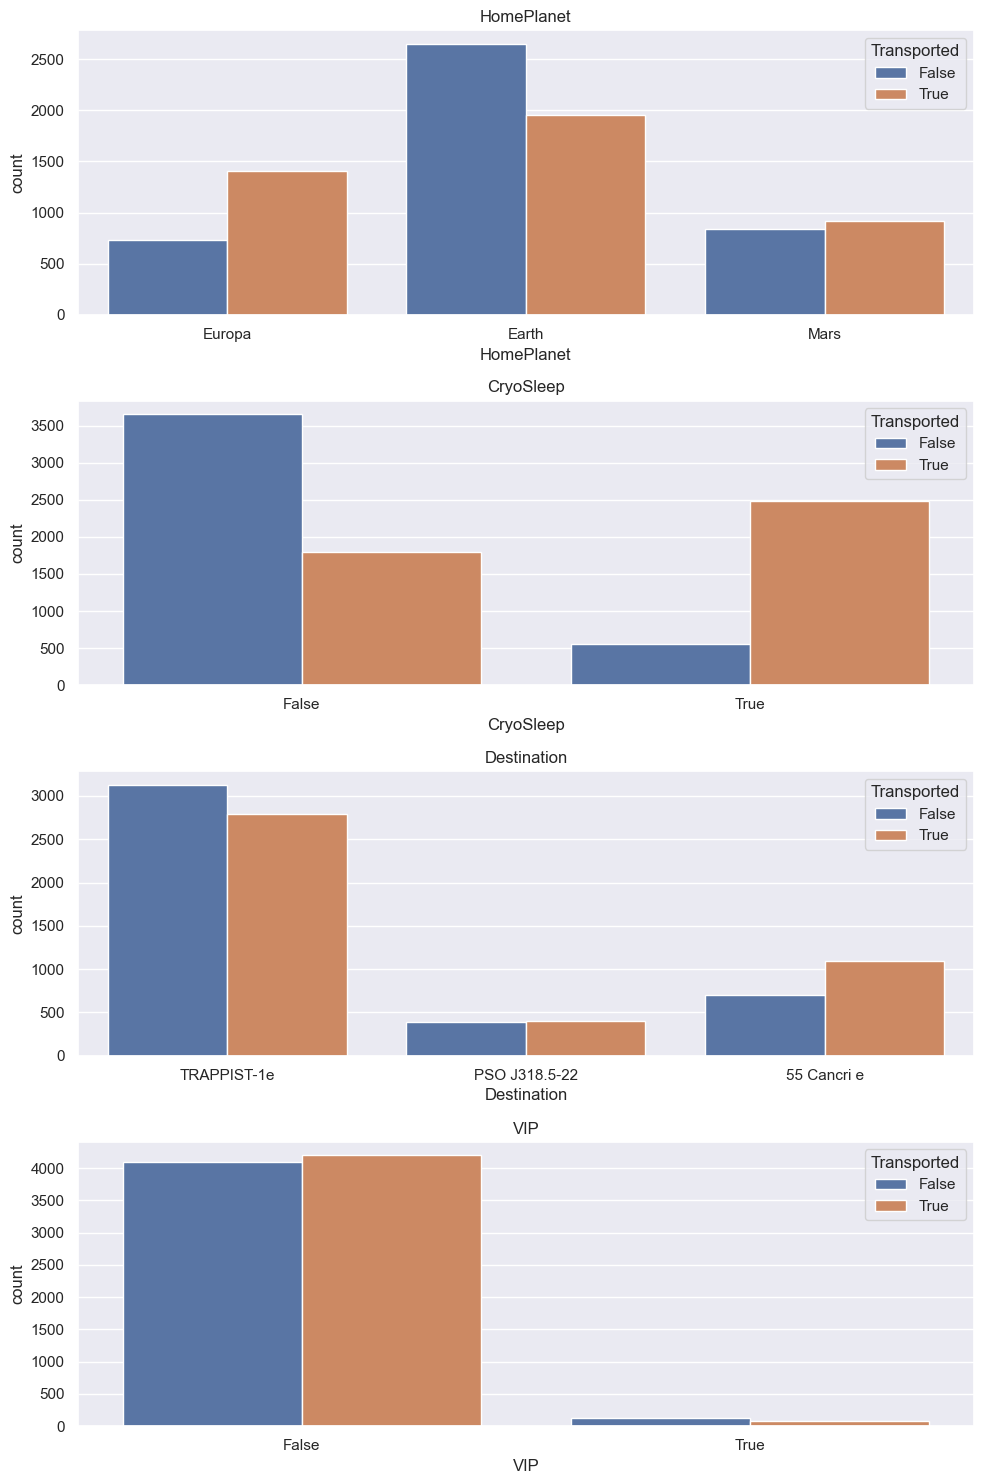

In [9]:
cat_feats = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig = plt.figure(figsize=(10, 15))

for i, feat_name in enumerate(cat_feats):
    ax = fig.add_subplot(4, 1, i+1)

    sns.countplot(
        data=train,
        x=feat_name,
        axes=ax,
        hue='Transported'
    )

    ax.set_title(feat_name)
fig.tight_layout()
plt.show()

*Вывод:*

* Большинство пассажиров "CryoSleep" перенеслись;
* Признак "VIP" кажется не очень важным ввиду баланса в соотношении.

Теперь взглянем на численные признаки.

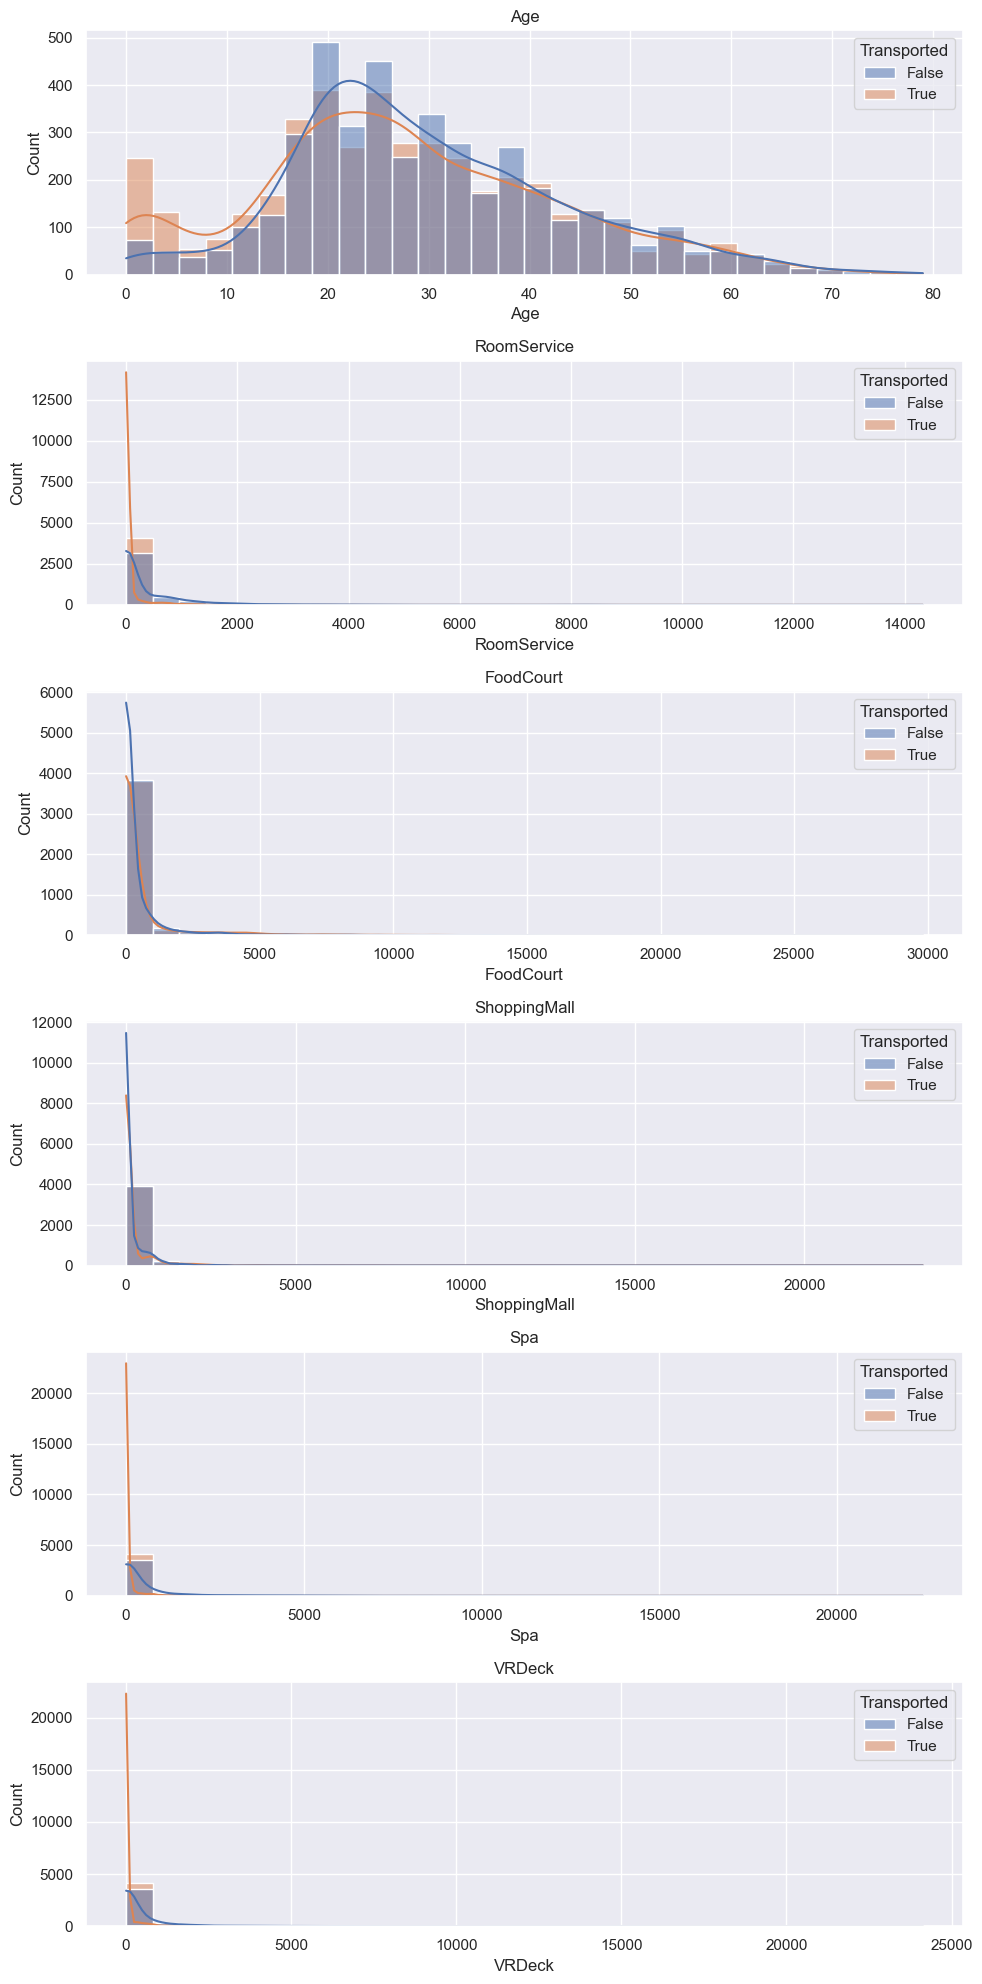

In [10]:
feats = ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig = plt.figure(figsize=(10, 20))

for i, feat_name in enumerate(feats):
    ax = fig.add_subplot(6, 1, 1*i+1)

    sns.histplot(
        data=train,
        x=feat_name,
        axes=ax,
        bins=30,
        hue='Transported',
        kde = True
    )

    ax.set_title(feat_name)
fig.tight_layout()
plt.show()

*Выводы:*
* Люди в возрасте 0-17 лет перенеслись в другое измерение (Tranported True);
* Люди в возрасте 18-40 лет не перенеслись в другое измерение (Tranported True);
* Люди старше 40 лет распределены примерно одинаково;
* Можно создать новый признак, разбивающий пассажиров по возрасту на 3 класса;


* Большинство пассажиров не тратили деньги на различные удобства;
* Можно создать новый бинарный признак, где 0 - люди которые не тратили денег вообще.

Посмотрим на наличие пропусков в данных.

In [11]:
train.isnull().sum().sort_values(ascending = False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

Напишем функцию и визауализируем пропуски.

In [12]:
def percent_missing(df):
    missing_num = df[df.columns].isna().sum().sort_values(ascending=False)
    missing_perc = (df[df.columns].isna().sum()/len(df)*100).sort_values(ascending=False)
    missing_data = pd.concat([missing_num,missing_perc],keys=['Total','Percentage'],axis=1)
    missing_data = missing_data[missing_data['Percentage']>0]
       
    return missing_data

In [13]:
percent_missing(train)

Total  Percentage
CryoSleep       217    2.496261
ShoppingMall    208    2.392730
VIP             203    2.335212
HomePlanet      201    2.312205
Name            200    2.300702
Cabin           199    2.289198
VRDeck          188    2.162660
FoodCourt       183    2.105142
Spa             183    2.105142
Destination     182    2.093639
RoomService     181    2.082135
Age             179    2.059128

In [14]:
percent_missing(test)

Total  Percentage
FoodCourt       106    2.478373
Spa             101    2.361468
Cabin           100    2.338087
ShoppingMall     98    2.291326
Name             94    2.197802
CryoSleep        93    2.174421
VIP              93    2.174421
Destination      92    2.151040
Age              91    2.127660
HomePlanet       87    2.034136
RoomService      82    1.917232
VRDeck           80    1.870470

Text(0.5, 1.0, 'Percent missing data by feature on test data')

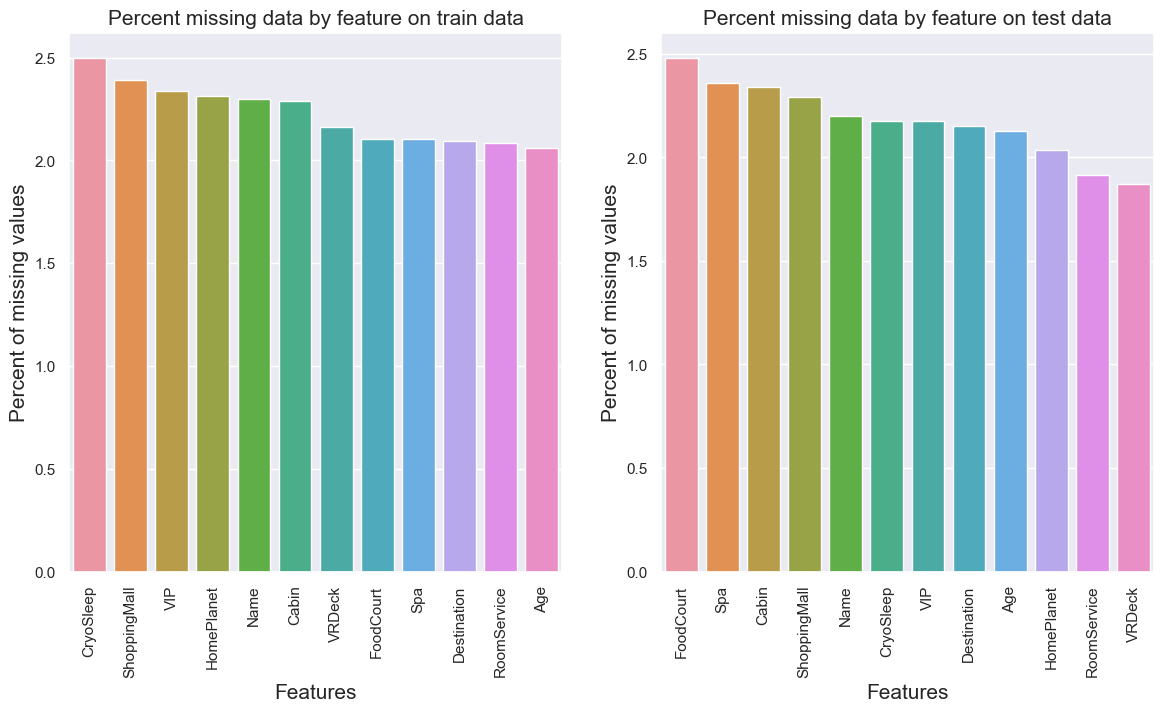

In [15]:
f, ax = plt.subplots(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.barplot(
    x=percent_missing(train).index,
    y=percent_missing(train).Percentage
)

plt.xticks(rotation=90)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature on train data', fontsize=15)

plt.subplot(1, 2, 2)
sns.barplot(
    x=percent_missing(test).index,
    y=percent_missing(test).Percentage
)

plt.xticks(rotation=90)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature on test data', fontsize=15)

In [16]:
train.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

In [17]:
test

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
4272     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
4273     9269_01      Earth     False       NaN    TRAPPIST-1e  42.0  False   
4274     9271_01       Mars      True   D/296/P    55 Cancri e   NaN  False   
4275     9273_01     Europa     False   D/297/P            NaN   NaN  False   
4276     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0             0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1             0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2             0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3             0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4            10.0        0.0         635.0     0.0     0.0   Brence Harperez  
...           ...        ...           ...     ...     ...               ...  
4272          0.0        0.0           0.0     0.0     0.0       Jeron Peter  
4273          0.0      847.0          17.0    10.0   144.0     Matty Scheron  
4274          0.0        0.0           0.0     0.0     0.0       Jayrin Pore  
4275          0.0     2680.0           0.0     0.0   523.0    Kitakan Conale  
4276          0.0        0.0           0.0     0.0     0.0  Lilace Leonzaley  

[4277 rows x 13 columns]

# **3. Feature engineering**

При анализе данных мы не рассмотрели еще 2 категориальных признака: `PassengerId` и `Cabin`.

Разобьем пассажиров на группы и подсчитаем их количество в каждой группе.

In [18]:
#Соединим тестовую и обучающую выборки.
train['istest'] = 0
test['istest'] = 1

raw = pd.concat((train, test)).reset_index(drop=True)

In [19]:
raw

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0         0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1         0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2         0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3         0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4         0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...           ...        ...       ...       ...            ...   ...    ...   
12965     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
12966     9269_01      Earth     False       NaN    TRAPPIST-1e  42.0  False   
12967     9271_01       Mars      True   D/296/P    55 Cancri e   NaN  False   
12968     9273_01     Europa     False   D/297/P            NaN   NaN  False   
12969     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   

       RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
0              0.0        0.0           0.0     0.0     0.0   
1            109.0        9.0          25.0   549.0    44.0   
2             43.0     3576.0           0.0  6715.0    49.0   
3              0.0     1283.0         371.0  3329.0   193.0   
4            303.0       70.0         151.0   565.0     2.0   
...            ...        ...           ...     ...     ...   
12965          0.0        0.0           0.0     0.0     0.0   
12966          0.0      847.0          17.0    10.0   144.0   
12967          0.0        0.0           0.0     0.0     0.0   
12968          0.0     2680.0           0.0     0.0   523.0   
12969          0.0        0.0           0.0     0.0     0.0   

                    Name Transported  istest  
0        Maham Ofracculy       False       0  
1           Juanna Vines        True       0  
2          Altark Susent       False       0  
3           Solam Susent       False       0  
4      Willy Santantines        True       0  
...                  ...         ...     ...  
12965        Jeron Peter         NaN       1  
12966      Matty Scheron         NaN       1  
12967        Jayrin Pore         NaN       1  
12968     Kitakan Conale         NaN       1  
12969   Lilace Leonzaley         NaN       1  

[12970 rows x 15 columns]

In [20]:
raw['Group'] = raw.PassengerId.apply(lambda x: x.split('_')[0]).astype(int)
raw['Group_size']=raw['Group'].map(lambda x: raw['Group'].value_counts()[x])

In [21]:
raw.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

  Transported  istest  Group  Group_size  
0       False       0      1           1  
1        True       0      2           1  
2       False       0      3           2  
3       False       0      3           2  
4        True       0      4           1

Оценим влияние группы на выживаемость

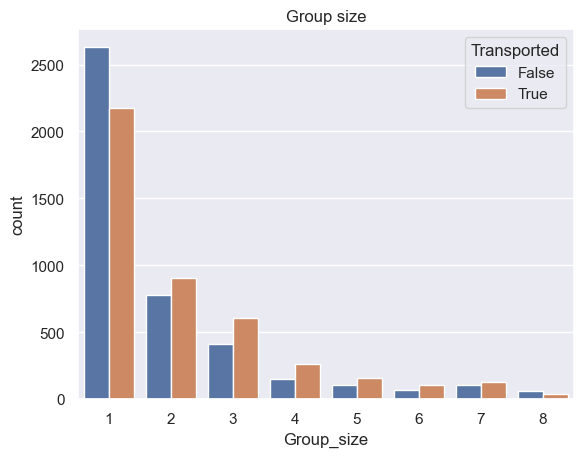

In [22]:
sns.countplot(data=raw, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

Люди в группах скорее переносились. 

Создадим еще одну группу, которая показывает путешествовал ли человек в одиночку.

In [23]:
raw['Solo']=(raw['Group_size']==1).astype(int)

Text(0.5, 1.0, 'Passenger travelling solo or not')

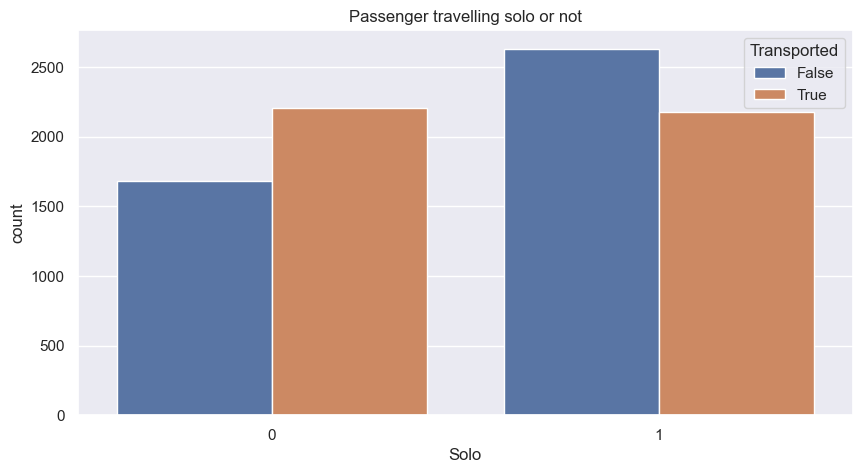

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(data=raw, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')

Теперь посмотрим на признак `Cabin`.

In [25]:
# Заменим значения NaN, инчае мы не сможем выполнить сплит.
raw['Cabin'].fillna('NaN/NaN/NaN', inplace=True)

In [26]:
raw['Deck'] = raw.Cabin.apply(lambda x: x.split('/')[0])
raw['Cabin_number'] = raw.Cabin.apply(lambda x: x.split('/')[1])
raw['Cabin_side'] = raw.Cabin.apply(lambda x: x.split('/')[2])

In [27]:
raw

PassengerId HomePlanet CryoSleep        Cabin    Destination   Age  \
0         0001_01     Europa     False        B/0/P    TRAPPIST-1e  39.0   
1         0002_01      Earth     False        F/0/S    TRAPPIST-1e  24.0   
2         0003_01     Europa     False        A/0/S    TRAPPIST-1e  58.0   
3         0003_02     Europa     False        A/0/S    TRAPPIST-1e  33.0   
4         0004_01      Earth     False        F/1/S    TRAPPIST-1e  16.0   
...           ...        ...       ...          ...            ...   ...   
12965     9266_02      Earth      True     G/1496/S    TRAPPIST-1e  34.0   
12966     9269_01      Earth     False  NaN/NaN/NaN    TRAPPIST-1e  42.0   
12967     9271_01       Mars      True      D/296/P    55 Cancri e   NaN   
12968     9273_01     Europa     False      D/297/P            NaN   NaN   
12969     9277_01      Earth      True     G/1498/S  PSO J318.5-22  43.0   

         VIP  RoomService  FoodCourt  ShoppingMall  ...  VRDeck  \
0      False          0.0        0.0           0.0  ...     0.0   
1      False        109.0        9.0          25.0  ...    44.0   
2       True         43.0     3576.0           0.0  ...    49.0   
3      False          0.0     1283.0         371.0  ...   193.0   
4      False        303.0       70.0         151.0  ...     2.0   
...      ...          ...        ...           ...  ...     ...   
12965  False          0.0        0.0           0.0  ...     0.0   
12966  False          0.0      847.0          17.0  ...   144.0   
12967  False          0.0        0.0           0.0  ...     0.0   
12968  False          0.0     2680.0           0.0  ...   523.0   
12969  False          0.0        0.0           0.0  ...     0.0   

                    Name Transported istest  Group  Group_size  Solo  Deck  \
0        Maham Ofracculy       False      0      1           1     1     B   
1           Juanna Vines        True      0      2           1     1     F   
2          Altark Susent       False      0      3           2     0     A   
3           Solam Susent       False      0      3           2     0     A   
4      Willy Santantines        True      0      4           1     1     F   
...                  ...         ...    ...    ...         ...   ...   ...   
12965        Jeron Peter         NaN      1   9266           2     0     G   
12966      Matty Scheron         NaN      1   9269           1     1   NaN   
12967        Jayrin Pore         NaN      1   9271           1     1     D   
12968     Kitakan Conale         NaN      1   9273           1     1     D   
12969   Lilace Leonzaley         NaN      1   9277           1     1     G   

      Cabin_number Cabin_side  
0                0          P  
1                0          S  
2                0          S  
3                0          S  
4                1          S  
...            ...        ...  
12965         1496          S  
12966          NaN        NaN  
12967          296          P  
12968          297          P  
12969         1498          S  

[12970 rows x 21 columns]

In [28]:
raw[['Deck', "Cabin_number", "Cabin_side", "Transported"]]

Deck Cabin_number Cabin_side Transported
0        B            0          P       False
1        F            0          S        True
2        A            0          S       False
3        A            0          S       False
4        F            1          S        True
...    ...          ...        ...         ...
12965    G         1496          S         NaN
12966  NaN          NaN        NaN         NaN
12967    D          296          P         NaN
12968    D          297          P         NaN
12969    G         1498          S         NaN

[12970 rows x 4 columns]

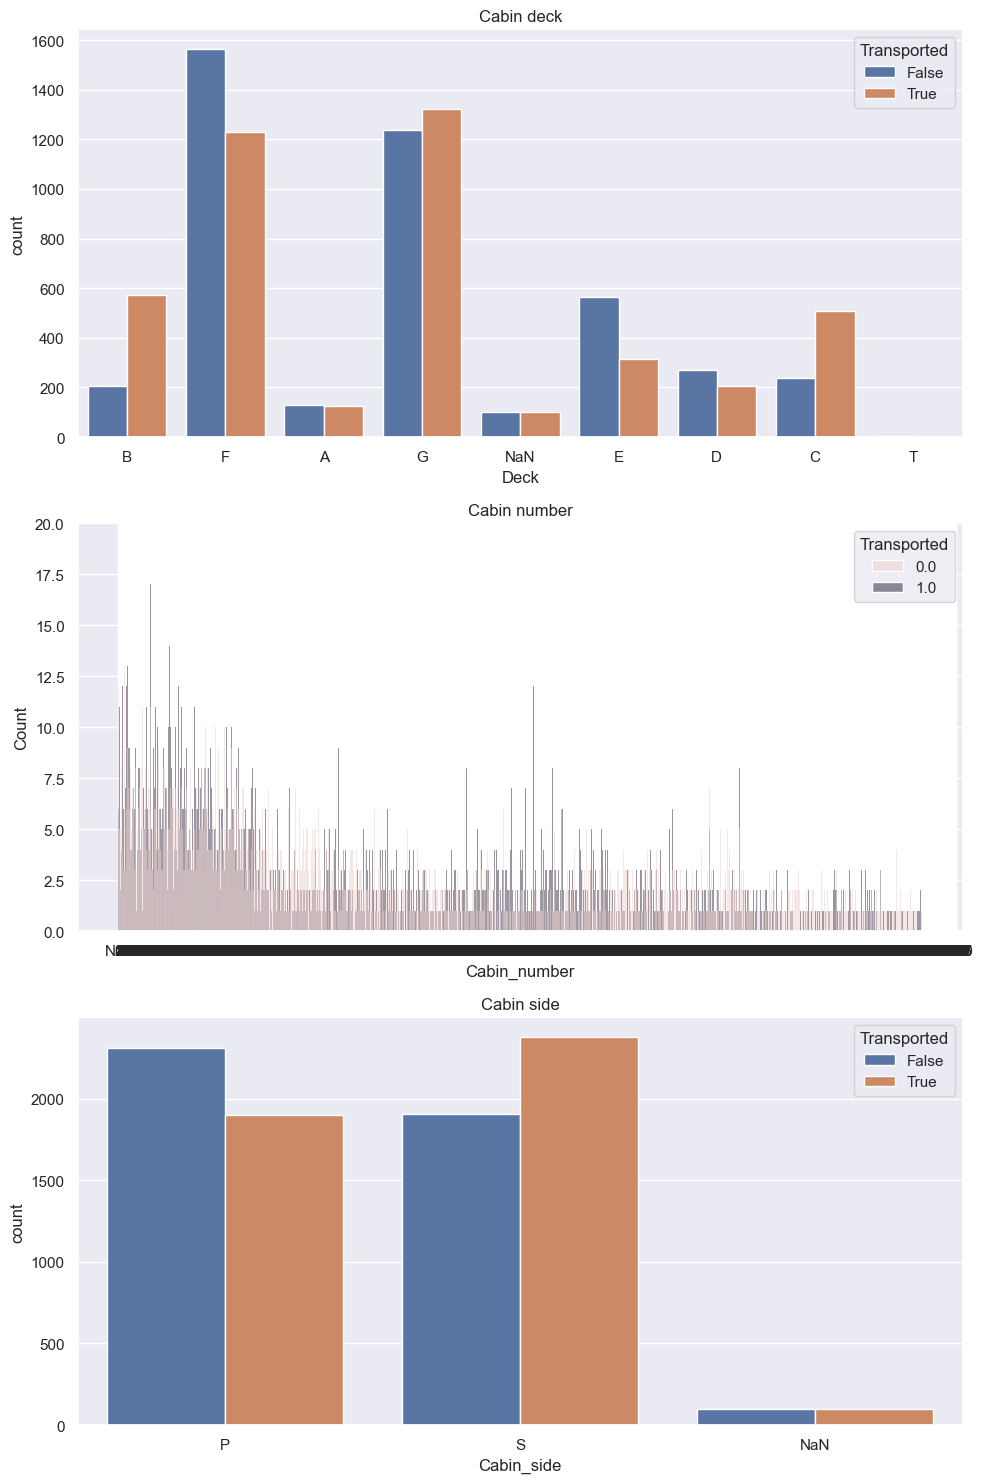

In [29]:
fig=plt.figure(figsize=(10,15))

plt.subplot(3,1,1)
sns.countplot(
    data=raw,
    x='Deck',
    hue='Transported')
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(
    data=raw,
    x='Cabin_number',
    hue='Transported'
    ,binwidth=20)
plt.ylim([0, 20])
plt.title('Cabin number')

plt.subplot(3,1,3)
sns.countplot(
    data=raw,
    x='Cabin_side',
    hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

Теперь создадим признак отвечающий за дополнительные расходы.

In [30]:
raw['Total_Expenditure'] = raw[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

raw['No_spending'] = (raw['Total_Expenditure'] == 0).astype(int)

Text(0.5, 1.0, 'No_spending')

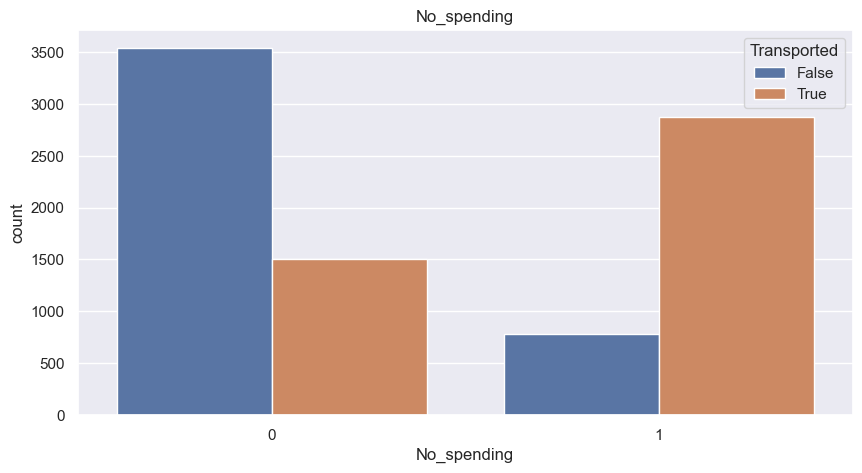

In [31]:
fig = plt.figure(figsize=(10, 5))

sns.countplot(
    data=raw,
    x='No_spending',
    hue='Transported')
plt.title('No_spending')

## **Filling in Missing Values**

Заполним признак `HomePlanet`. Так как в задаче сказано что это планета с которой вылетел пассажир, предположим что люди из одной группы вылетели вместе.

In [32]:
group = raw.groupby(['Group', 'HomePlanet'])['HomePlanet'] \
    .count().unstack().fillna(0)
group

HomePlanet  Earth  Europa  Mars
Group                          
1             0.0     1.0   0.0
2             1.0     0.0   0.0
3             0.0     2.0   0.0
4             1.0     0.0   0.0
5             1.0     0.0   0.0
...           ...     ...   ...
9276          0.0     1.0   0.0
9277          1.0     0.0   0.0
9278          1.0     0.0   0.0
9279          1.0     0.0   0.0
9280          0.0     2.0   0.0

[9124 rows x 3 columns]

In [33]:
miss_val_bef = raw['HomePlanet'].isna().sum()
miss_val_bef

288

In [34]:
group_index = raw[raw['HomePlanet'].isna()][(raw[raw['HomePlanet'].isna()]['Group'])
                                            .isin(group.index)].index

In [35]:
raw.loc[group_index, 'HomePlanet'] = raw.iloc[group_index, :]['Group'] \
    .map(lambda x: group.idxmax(axis=1)[x])

In [36]:
print("Percentage of remaining missing values : %0.2f)" % (raw['HomePlanet'].isna().sum() / miss_val_bef * 100))

Percentage of remaining missing values : 54.51)


Практически половину пропусков таким образом мы заполнили.

Посмотрим как разместились пассажиры с разных планет по палубам.

<AxesSubplot: xlabel='Deck', ylabel='HomePlanet'>

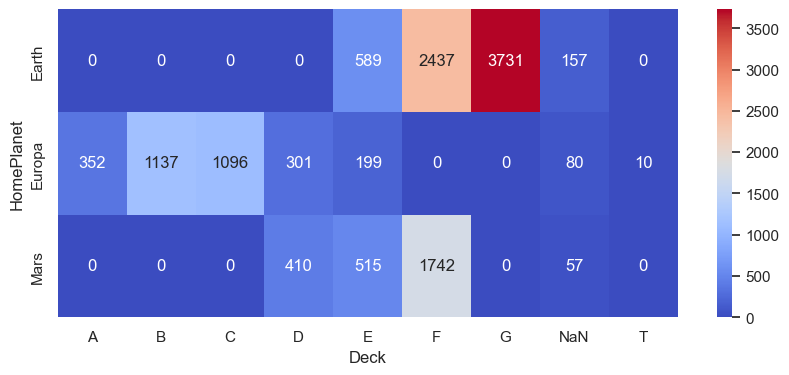

In [37]:
cabin = raw.groupby(['Deck', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

plt.figure(figsize=(10, 4))
sns.heatmap(cabin.T, annot=True, fmt='g', cmap='coolwarm')

Выводы:
- Кабины A,B,C,T заняты пассажирами с Европы;
- Кабина G занята только пассажипами с Земли.

In [38]:
miss_val_bef = raw['HomePlanet'].isna().sum()

In [39]:
raw.loc[(raw['HomePlanet'].isna()) & (raw['Deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'

raw.loc[(raw['HomePlanet'].isna()) & (raw['Deck'] == 'G'), 'HomePlanet'] = 'Earth'

In [40]:
print("Percentage of remaining missing values : %0.2f)" % (raw['HomePlanet'].isna().sum() / miss_val_bef * 100))

Percentage of remaining missing values : 59.87)


Посмотрим куда направлялись пассажиры с разных планет.

<AxesSubplot: xlabel='HomePlanet', ylabel='Destination'>

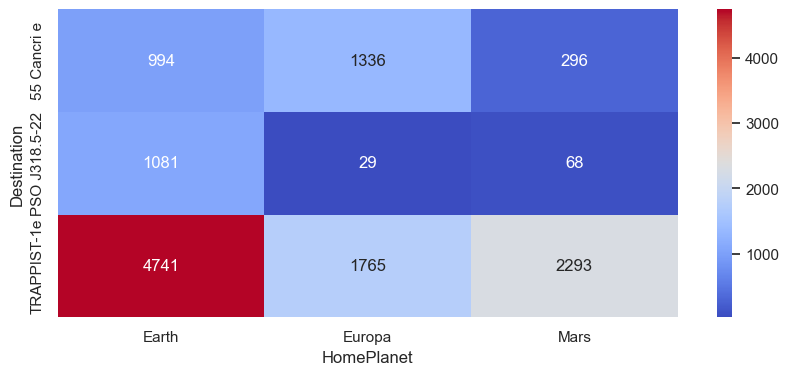

In [41]:
Destination = raw.groupby(['HomePlanet', 'Destination'])['Destination'].size().unstack().fillna(0)

plt.figure(figsize=(10, 4))
sns.heatmap(Destination.T, annot=True, fmt='g', cmap='coolwarm')

Большинство прибыло с Земли и отправлялись на TRAPPIST-1e. Заполним остальные пропуски в соответсвтии с этим выводом.

In [42]:
#Учтем, что в кабинах D пассажиров с Земли не было
raw.loc[(raw['HomePlanet'].isna()) & ~(raw['Deck']=='D'), 'HomePlanet']='Earth'
raw.loc[(raw['HomePlanet'].isna()) & (raw['Deck']=='D'), 'HomePlanet']='Mars'

In [43]:
raw['HomePlanet'].isna().sum()

0

In [44]:
raw['Destination'] = raw['Destination'].fillna('TRAPPIST-1e')

Очевидно, пассажиры которые тратили деньги имеют CryoSleep False

In [45]:
raw.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep     False   True 
No_spending                
0            7339.0     0.0
1             740.0  4581.0

In [46]:
na_Cryo = raw.loc[raw['CryoSleep'].isna(), 'CryoSleep'].index
raw.loc[raw['CryoSleep'].isna(), 'CryoSleep'] = raw.groupby(['No_spending'])['CryoSleep'] \
    .transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_Cryo]

Преобразуем Bool в int

In [47]:
raw['CryoSleep'] = raw['CryoSleep'].astype(int)

Так как VIP пассажиров значительно меньше, преобразуем в int и заполним пропуски нулями.

In [48]:
raw['VIP'] = 1*(raw['VIP'])
raw['VIP'] = raw['VIP'].fillna(0)

Заменим числовые признаки медианным значением

In [49]:
for col in feats:
    raw[col]=raw[col].fillna(raw.groupby(['HomePlanet','Solo','No_spending'])[col].transform('median'))

Разобьем наших пассажиров по возрасту.


In [50]:
raw['Age_group'] = np.nan
raw.loc[raw['Age'] <= 17, 'Age_group'] = 'Age_0-17'
raw.loc[(raw['Age'] > 17) & (raw['Age'] <= 40), 'Age_group'] = 'Age_18-40'
raw.loc[raw['Age'] > 40, 'Age_group'] = 'Age_40+'

In [51]:
raw.isna().sum()

PassengerId             0
HomePlanet              0
CryoSleep               0
Cabin                   0
Destination             0
Age                     0
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Name                  294
Transported          4277
istest                  0
Group                   0
Group_size              0
Solo                    0
Deck                    0
Cabin_number            0
Cabin_side              0
Total_Expenditure       0
No_spending             0
Age_group               0
dtype: int64

# **4. Data Preprocessing**

Отбросим ненужные столбцы 

In [52]:
raw1 = raw.drop(['PassengerId', 'Name', 'Cabin', 'Cabin_number', 'Cabin_side', 'Group', 'Cabin'], axis=1)

In [56]:
train = raw1[raw1['istest'] == 0].drop(['istest'], axis=1)
test = raw1[raw1['istest'] == 1].drop(['istest', 'Transported'], axis=1)

Нормируем числовые признаки.

In [63]:
columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Total_Expenditure']

for col in columns:
    train[col]=np.log(1+train[col])
    test[col]=np.log(1+test[col])

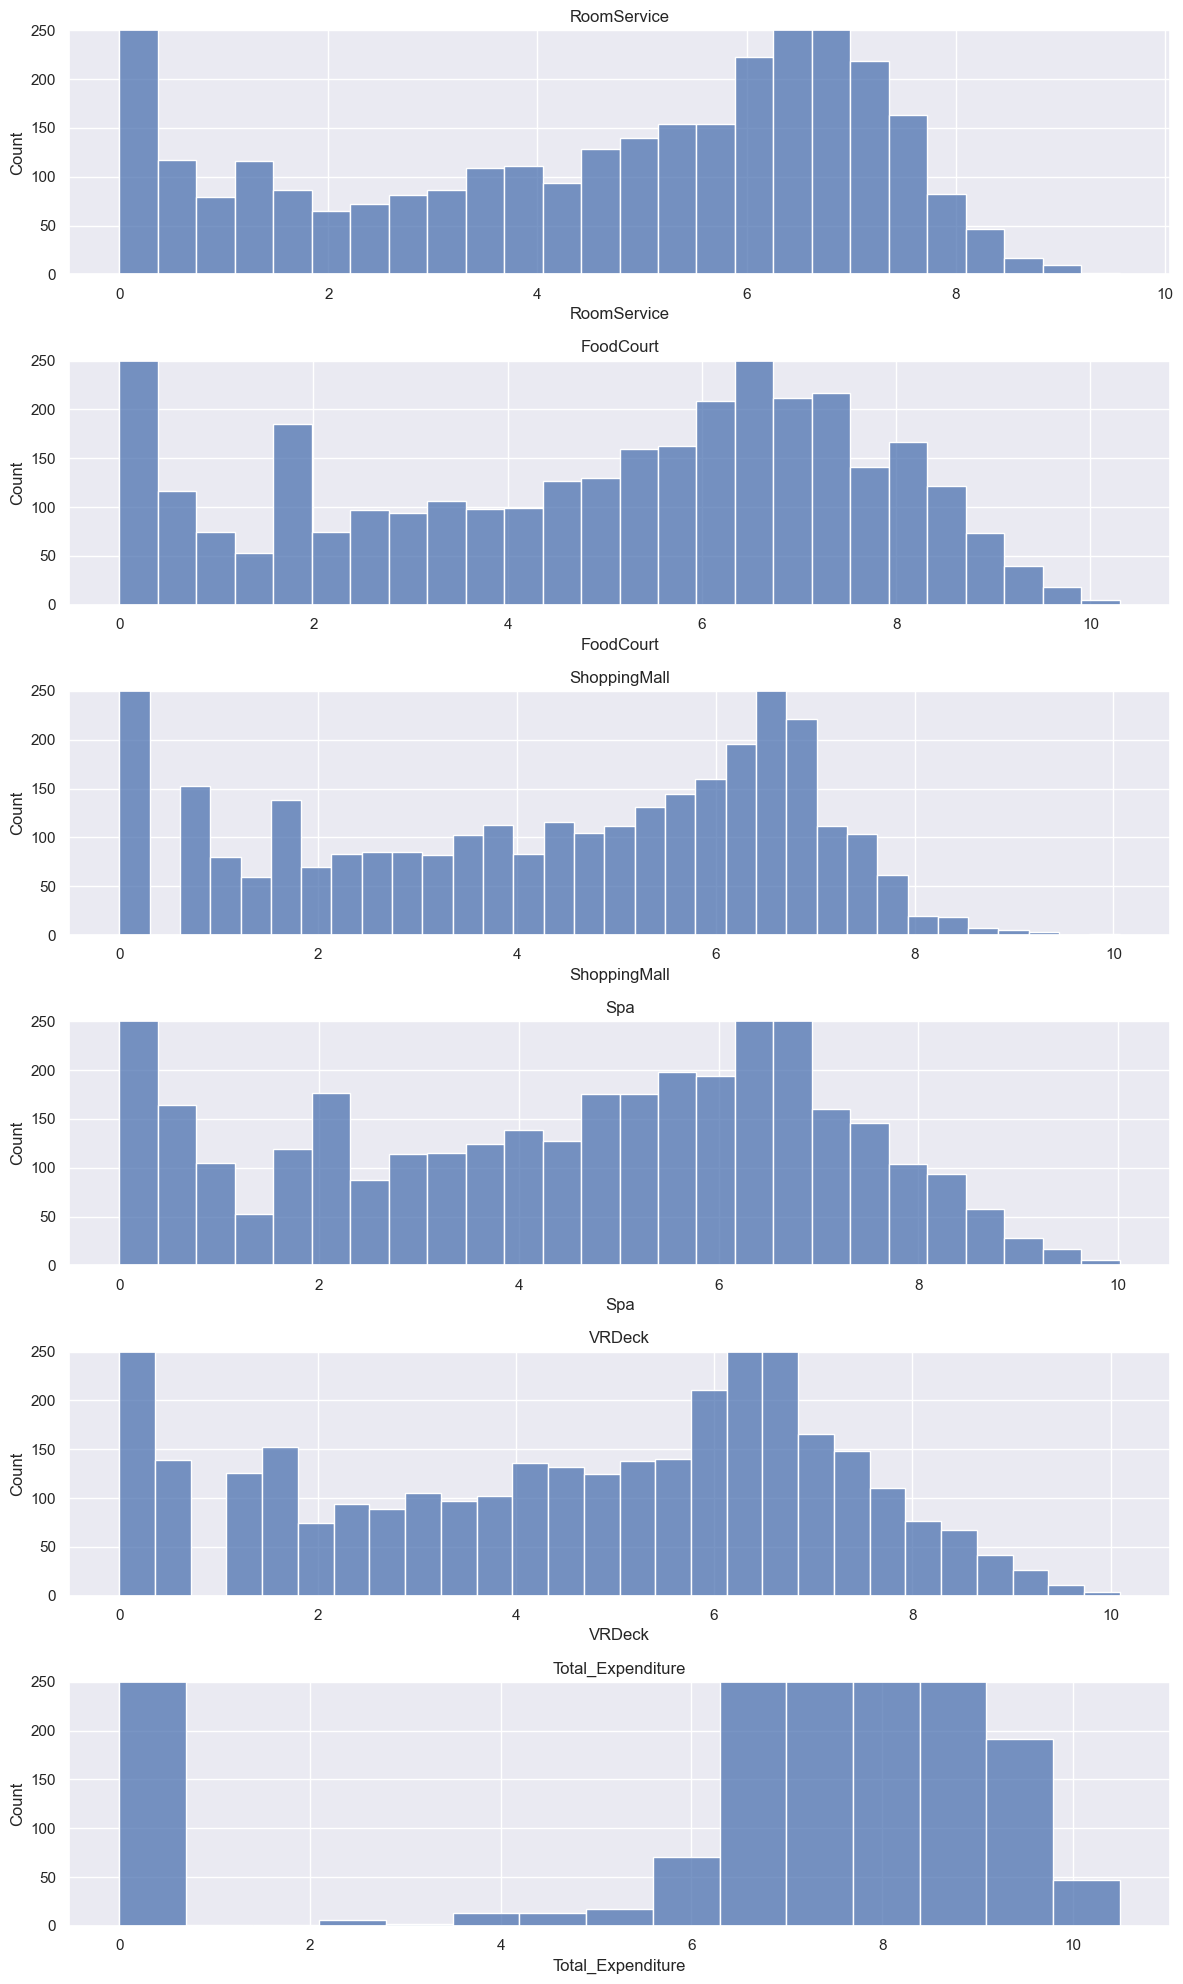

In [64]:
fig=plt.figure(figsize=(12,20))

for i, col in enumerate(columns):
    plt.subplot(6,1,1*i+1)
    sns.histplot(train[col])
    plt.ylim([0,250])
    plt.title(col)
    
fig.tight_layout()
plt.show()

In [271]:
train[[*cat_feats, 'Age_group', 'Deck']].nunique()

HomePlanet     3
CryoSleep      2
Destination    3
VIP            2
Age_group      3
Deck           9
dtype: int64

Преобразуем категориальные признаки c помощью OneHotEncoding, а Deck TargetEncoding (CryoSleep и VIP уже преобразовали до этого)

In [57]:
y = train['Transported'].copy().astype(int)
train.drop(['Transported'], axis=1, inplace=True)

In [58]:
target_encoder = train.Deck

In [59]:
encoder = ce.cat_boost.CatBoostEncoder()

In [60]:
encoder.fit(target_encoder, y)
train.Deck = encoder.transform(target_encoder)
test.Deck = encoder.transform(test.Deck)

In [61]:
def get_dummies(DataFrame, columns):
    dummies = pd.get_dummies(DataFrame[columns], drop_first=True).columns
    DataFrame[dummies] = pd.get_dummies(DataFrame[columns], drop_first=True)
    
    return DataFrame.drop(columns, axis=1)

In [62]:
train = get_dummies(train, ['HomePlanet','Destination', 'Age_group'])
test = get_dummies(test, ['HomePlanet','Destination', 'Age_group'])

Отмасштабируем наши числовые признаки

In [65]:
scaler = StandardScaler()

In [66]:
scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(train, y, stratify=y, train_size=0.8, test_size=0.2, random_state=777)

# **5. Models**

In [140]:
def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier", ["LogReg", "KNN", "SVC", "RF", "XGB", "LGBM", "CatBoost"])

    if classifier_name == "LogReg":
        C = trial.suggest_float('C', 1e-10, 1e10, log=True)
        classifier_obj = LogisticRegression(C=C, random_state=777)

    elif classifier_name == "KNN":
        n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
        classifier_obj = KNeighborsClassifier(
            n_neighbors=n_neighbors)

    elif classifier_name == "SVC":
        C = trial.suggest_float('C', 0.25, 1e4, log=True)
        classifier_obj = SVC(C=C, random_state=777)

    elif classifier_name == "RF":
        params = {
            'random_state': 777,
            'n_estimators': trial.suggest_int("n_estimators", 10, 1000),
            'max_depth':  trial.suggest_int("max_depth", 2, 32, log=True),
            'min_samples_split': trial.suggest_int("min_samples_split", 2, 100),
            'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 50),
        }
        classifier_obj = RandomForestClassifier(**params)

    elif classifier_name == "XGB":
        params = {
            'random_state': 777,
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3,  1.0),
            'subsample': trial.suggest_float('subsample', 0.4, 1.0),
            'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            'n_estimators': 10000,
            'max_depth': trial.suggest_int('max_depth', 2, 30, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
        }
        classifier_obj = XGBClassifier(**params)

    elif classifier_name == "LGBM":
        params = {
            'metric': 'rmse',
            'random_state': 777,
            'n_estimators': 20000,
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'subsample': trial.suggest_float('subsample', 0.4, 1.0),
            'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 30, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 1, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth': trial.suggest_int('min_data_per_groups', 1, 100)
        }
        classifier_obj = LGBMClassifier(**params)

    elif classifier_name == "CatBoost":
        params = {
            'random_state': 777,
            'iterations': trial.suggest_int("iterations", 100, 1000),
            'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            'depth': trial.suggest_int("depth", 4, 10),
            'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
            'bootstrap_type': trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
            'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
            'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
            'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
            'od_wait': trial.suggest_int("od_wait", 10, 50),
        }
        classifier_obj = CatBoostClassifier(**params, verbose=False)

    classifier_obj.fit(X_train, y_train)
    y_pred = classifier_obj.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [150]:
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=100, reduction_factor=3
    ),
)
study.optimize(objective, n_trials=100)

[I 2023-02-07 11:50:45,037] A new study created in memory with name: no-name-53fe5583-071f-49c7-a203-a3fa0b4d1fde
[I 2023-02-07 11:50:45,064] Trial 0 finished with value: 0.7648073605520413 and parameters: {'classifier': 'LogReg', 'C': 0.4566912171890757}. Best is trial 0 with value: 0.7648073605520413.
[I 2023-02-07 11:51:16,951] Trial 1 finished with value: 0.7567567567567568 and parameters: {'classifier': 'SVC', 'C': 1955.8818774811318}. Best is trial 0 with value: 0.7648073605520413.
[I 2023-02-07 11:51:18,906] Trial 2 finished with value: 0.8021851638872916 and parameters: {'classifier': 'CatBoost', 'iterations': 374, 'learning_rate': 0.01449044025527716, 'depth': 7, 'l2_leaf_reg': 6.782251665729798e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 0.004453552692487147, 'bagging_temperature': 1.187465509903437, 'od_type': 'IncToDec', 'od_wait': 50}. Best is trial 2 with value: 0.8021851638872916.
[I 2023-02-07 11:51:30,712] Trial 3 finished with value: 0.8039102932719954 and p

[I 2023-02-07 11:54:08,783] Trial 23 finished with value: 0.7809085681426107 and parameters: {'classifier': 'CatBoost', 'iterations': 827, 'learning_rate': 0.0014165457553497348, 'depth': 7, 'l2_leaf_reg': 0.03280939944221067, 'bootstrap_type': 'Bayesian', 'random_strength': 3.8808647822139875e-07, 'bagging_temperature': 6.075981839859334, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 18 with value: 0.8079355951696378.
[I 2023-02-07 11:54:26,561] Trial 24 finished with value: 0.7924094307073031 and parameters: {'classifier': 'LGBM', 'reg_alpha': 0.2567165083280742, 'reg_lambda': 0.004659117844570625, 'colsample_bytree': 0.5457921528664844, 'subsample': 0.5550200585929934, 'learning_rate': 0.019551434443330313, 'max_depth': 10, 'num_leaves': 224, 'min_child_samples': 170, 'min_data_per_groups': 48}. Best is trial 18 with value: 0.8079355951696378.
[I 2023-02-07 11:54:28,820] Trial 25 finished with value: 0.7906843013225991 and parameters: {'classifier': 'CatBoost', 'iterations': 111,

[I 2023-02-07 11:57:38,109] Trial 45 finished with value: 0.7889591719378953 and parameters: {'classifier': 'RF', 'n_estimators': 868, 'max_depth': 28, 'min_samples_split': 96, 'min_samples_leaf': 48}. Best is trial 41 with value: 0.816561242093157.
[I 2023-02-07 11:57:45,138] Trial 46 finished with value: 0.7993099482461185 and parameters: {'classifier': 'CatBoost', 'iterations': 676, 'learning_rate': 0.0171349761099061, 'depth': 9, 'l2_leaf_reg': 69.83478651786596, 'bootstrap_type': 'Bayesian', 'random_strength': 1.4144373452840318e-07, 'bagging_temperature': 6.256971626221023, 'od_type': 'IncToDec', 'od_wait': 36}. Best is trial 41 with value: 0.816561242093157.
[I 2023-02-07 11:57:53,199] Trial 47 finished with value: 0.79700977573318 and parameters: {'classifier': 'CatBoost', 'iterations': 768, 'learning_rate': 0.034608028390109076, 'depth': 9, 'l2_leaf_reg': 0.025390276793017565, 'bootstrap_type': 'Bayesian', 'random_strength': 5.105586329088047e-06, 'bagging_temperature': 1.3129

[I 2023-02-07 11:59:49,105] Trial 67 finished with value: 0.7889591719378953 and parameters: {'classifier': 'XGB', 'lambda': 0.06971169400442741, 'alpha': 0.0013283300399534045, 'colsample_bytree': 0.7423788809966015, 'subsample': 0.7932081471788484, 'learning_rate': 0.05788815325547573, 'max_depth': 3, 'min_child_weight': 120}. Best is trial 41 with value: 0.816561242093157.
[I 2023-02-07 11:59:49,201] Trial 68 finished with value: 0.7676825761932144 and parameters: {'classifier': 'KNN', 'n_neighbors': 16}. Best is trial 41 with value: 0.816561242093157.
[I 2023-02-07 11:59:52,303] Trial 69 finished with value: 0.8113858539390454 and parameters: {'classifier': 'CatBoost', 'iterations': 889, 'learning_rate': 0.07628864708902582, 'depth': 5, 'l2_leaf_reg': 0.04587037918515436, 'bootstrap_type': 'Bayesian', 'random_strength': 0.03204092039546048, 'bagging_temperature': 1.041872880903036, 'od_type': 'IncToDec', 'od_wait': 21}. Best is trial 41 with value: 0.816561242093157.
[I 2023-02-07 

[I 2023-02-07 12:01:43,834] Trial 88 finished with value: 0.8033352501437608 and parameters: {'classifier': 'CatBoost', 'iterations': 721, 'learning_rate': 0.013807175695208942, 'depth': 7, 'l2_leaf_reg': 0.1752220650601329, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00010645999551304582, 'bagging_temperature': 7.464519360468907, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial 41 with value: 0.816561242093157.
[I 2023-02-07 12:01:43,922] Trial 89 finished with value: 0.7193789534215066 and parameters: {'classifier': 'KNN', 'n_neighbors': 1}. Best is trial 41 with value: 0.816561242093157.
[I 2023-02-07 12:01:58,920] Trial 90 finished with value: 0.7906843013225991 and parameters: {'classifier': 'XGB', 'lambda': 0.001353044057268499, 'alpha': 0.15196205589322093, 'colsample_bytree': 0.8643092175465759, 'subsample': 0.97216256882728, 'learning_rate': 0.025513477316679703, 'max_depth': 4, 'min_child_weight': 137}. Best is trial 41 with value: 0.816561242093157.
[I 2023-02-07 

In [216]:
models = study.trials_dataframe()

In [152]:
optuna.visualization.plot_optimization_history(study)

In [153]:
study.best_trial.params

{'classifier': 'CatBoost',
 'iterations': 655,
 'learning_rate': 0.02103785316323483,
 'depth': 9,
 'l2_leaf_reg': 0.4721755411519123,
 'bootstrap_type': 'Bayesian',
 'random_strength': 2.904729482644501e-06,
 'bagging_temperature': 0.11132174245985466,
 'od_type': 'IncToDec',
 'od_wait': 10}

In [156]:
best_params = {
    'iterations': 655,
    'learning_rate': 0.02103785316323483,
    'depth': 9,
    'l2_leaf_reg': 0.4721755411519123,
    'bootstrap_type': 'Bayesian',
    'random_strength': 2.904729482644501e-06,
    'bagging_temperature': 0.11132174245985466,
    'od_type': 'IncToDec',
    'od_wait': 10
}

In [205]:
cat = CatBoostClassifier(**best_params, verbose=False)
cat.fit(X_train, y_train)

y_pred = cat.predict(X_test)
accuracy_score(y_test, y_pred)

0.8154111558366878

In [227]:
FOLDS=10

cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=777)

score=0
for fold, (train_idx, val_idx) in enumerate(cv.split(train, y)):

    X_train, X_valid = train[train_idx], train[val_idx]
    y_train, y_valid = y[train_idx], y[val_idx]

    clf = CatBoostClassifier(**best_params)
    clf.fit(X_train, y_train)

    preds += clf.predict_proba(test)[:,1]
    score += clf.score(X_valid, y_valid)

preds=preds/(FOLDS)

0:	learn: 0.6784144	total: 10.8ms	remaining: 7.04s
1:	learn: 0.6645043	total: 21.1ms	remaining: 6.9s
2:	learn: 0.6513473	total: 30.7ms	remaining: 6.67s
3:	learn: 0.6390213	total: 40.5ms	remaining: 6.6s
4:	learn: 0.6276536	total: 49.4ms	remaining: 6.43s
5:	learn: 0.6168027	total: 58.4ms	remaining: 6.32s
6:	learn: 0.6066595	total: 67.4ms	remaining: 6.24s
7:	learn: 0.5980586	total: 76.6ms	remaining: 6.19s
8:	learn: 0.5897065	total: 85.5ms	remaining: 6.14s
9:	learn: 0.5810843	total: 94.2ms	remaining: 6.08s
10:	learn: 0.5738029	total: 104ms	remaining: 6.07s
11:	learn: 0.5660367	total: 113ms	remaining: 6.05s
12:	learn: 0.5594443	total: 122ms	remaining: 6.02s
13:	learn: 0.5525972	total: 131ms	remaining: 5.99s
14:	learn: 0.5465931	total: 140ms	remaining: 5.98s
15:	learn: 0.5397571	total: 149ms	remaining: 5.96s
16:	learn: 0.5343580	total: 159ms	remaining: 5.96s
17:	learn: 0.5285082	total: 168ms	remaining: 5.94s
18:	learn: 0.5228064	total: 177ms	remaining: 5.93s
19:	learn: 0.5182099	total: 188ms

164:	learn: 0.3534692	total: 1.66s	remaining: 4.94s
165:	learn: 0.3532184	total: 1.68s	remaining: 4.93s
166:	learn: 0.3525725	total: 1.69s	remaining: 4.93s
167:	learn: 0.3522176	total: 1.7s	remaining: 4.92s
168:	learn: 0.3518241	total: 1.71s	remaining: 4.91s
169:	learn: 0.3512317	total: 1.72s	remaining: 4.9s
170:	learn: 0.3507973	total: 1.73s	remaining: 4.89s
171:	learn: 0.3501675	total: 1.74s	remaining: 4.88s
172:	learn: 0.3499039	total: 1.75s	remaining: 4.87s
173:	learn: 0.3494282	total: 1.76s	remaining: 4.86s
174:	learn: 0.3489737	total: 1.77s	remaining: 4.85s
175:	learn: 0.3487029	total: 1.78s	remaining: 4.84s
176:	learn: 0.3482921	total: 1.79s	remaining: 4.83s
177:	learn: 0.3479402	total: 1.8s	remaining: 4.82s
178:	learn: 0.3476231	total: 1.81s	remaining: 4.8s
179:	learn: 0.3471434	total: 1.81s	remaining: 4.79s
180:	learn: 0.3468131	total: 1.82s	remaining: 4.78s
181:	learn: 0.3462093	total: 1.83s	remaining: 4.77s
182:	learn: 0.3457573	total: 1.84s	remaining: 4.75s
183:	learn: 0.34

330:	learn: 0.2962434	total: 3.32s	remaining: 3.25s
331:	learn: 0.2960569	total: 3.33s	remaining: 3.24s
332:	learn: 0.2958891	total: 3.34s	remaining: 3.23s
333:	learn: 0.2956754	total: 3.35s	remaining: 3.22s
334:	learn: 0.2953463	total: 3.36s	remaining: 3.21s
335:	learn: 0.2951753	total: 3.37s	remaining: 3.2s
336:	learn: 0.2949318	total: 3.38s	remaining: 3.19s
337:	learn: 0.2946246	total: 3.39s	remaining: 3.18s
338:	learn: 0.2943945	total: 3.4s	remaining: 3.17s
339:	learn: 0.2941557	total: 3.41s	remaining: 3.16s
340:	learn: 0.2940163	total: 3.42s	remaining: 3.15s
341:	learn: 0.2937616	total: 3.43s	remaining: 3.14s
342:	learn: 0.2935090	total: 3.44s	remaining: 3.13s
343:	learn: 0.2933732	total: 3.45s	remaining: 3.12s
344:	learn: 0.2929530	total: 3.46s	remaining: 3.11s
345:	learn: 0.2926272	total: 3.47s	remaining: 3.1s
346:	learn: 0.2923714	total: 3.48s	remaining: 3.08s
347:	learn: 0.2921837	total: 3.49s	remaining: 3.08s
348:	learn: 0.2920065	total: 3.5s	remaining: 3.06s
349:	learn: 0.29

500:	learn: 0.2593895	total: 4.99s	remaining: 1.53s
501:	learn: 0.2591636	total: 5s	remaining: 1.52s
502:	learn: 0.2588552	total: 5.01s	remaining: 1.51s
503:	learn: 0.2586774	total: 5.02s	remaining: 1.5s
504:	learn: 0.2585320	total: 5.03s	remaining: 1.49s
505:	learn: 0.2583669	total: 5.04s	remaining: 1.48s
506:	learn: 0.2582482	total: 5.05s	remaining: 1.47s
507:	learn: 0.2580432	total: 5.06s	remaining: 1.46s
508:	learn: 0.2578346	total: 5.07s	remaining: 1.45s
509:	learn: 0.2576633	total: 5.08s	remaining: 1.44s
510:	learn: 0.2575346	total: 5.09s	remaining: 1.43s
511:	learn: 0.2573209	total: 5.1s	remaining: 1.42s
512:	learn: 0.2570862	total: 5.11s	remaining: 1.41s
513:	learn: 0.2569787	total: 5.12s	remaining: 1.4s
514:	learn: 0.2566663	total: 5.13s	remaining: 1.39s
515:	learn: 0.2564521	total: 5.13s	remaining: 1.38s
516:	learn: 0.2563603	total: 5.14s	remaining: 1.37s
517:	learn: 0.2561653	total: 5.16s	remaining: 1.36s
518:	learn: 0.2560041	total: 5.16s	remaining: 1.35s
519:	learn: 0.2558

21:	learn: 0.5094139	total: 221ms	remaining: 6.34s
22:	learn: 0.5054950	total: 230ms	remaining: 6.33s
23:	learn: 0.5020597	total: 240ms	remaining: 6.31s
24:	learn: 0.4977593	total: 250ms	remaining: 6.3s
25:	learn: 0.4943984	total: 260ms	remaining: 6.28s
26:	learn: 0.4902888	total: 270ms	remaining: 6.29s
27:	learn: 0.4865540	total: 280ms	remaining: 6.27s
28:	learn: 0.4834119	total: 290ms	remaining: 6.25s
29:	learn: 0.4799971	total: 300ms	remaining: 6.24s
30:	learn: 0.4766918	total: 309ms	remaining: 6.22s
31:	learn: 0.4740082	total: 320ms	remaining: 6.22s
32:	learn: 0.4716133	total: 329ms	remaining: 6.21s
33:	learn: 0.4687172	total: 340ms	remaining: 6.2s
34:	learn: 0.4659173	total: 350ms	remaining: 6.19s
35:	learn: 0.4630140	total: 360ms	remaining: 6.2s
36:	learn: 0.4611831	total: 370ms	remaining: 6.19s
37:	learn: 0.4584732	total: 381ms	remaining: 6.19s
38:	learn: 0.4567591	total: 391ms	remaining: 6.17s
39:	learn: 0.4543185	total: 402ms	remaining: 6.17s
40:	learn: 0.4519854	total: 412ms	

185:	learn: 0.3446905	total: 1.86s	remaining: 4.68s
186:	learn: 0.3443528	total: 1.87s	remaining: 4.67s
187:	learn: 0.3439009	total: 1.88s	remaining: 4.66s
188:	learn: 0.3435504	total: 1.89s	remaining: 4.65s
189:	learn: 0.3432893	total: 1.9s	remaining: 4.64s
190:	learn: 0.3430559	total: 1.91s	remaining: 4.63s
191:	learn: 0.3428392	total: 1.92s	remaining: 4.62s
192:	learn: 0.3425079	total: 1.93s	remaining: 4.62s
193:	learn: 0.3420943	total: 1.94s	remaining: 4.6s
194:	learn: 0.3418379	total: 1.95s	remaining: 4.59s
195:	learn: 0.3415594	total: 1.96s	remaining: 4.58s
196:	learn: 0.3410950	total: 1.97s	remaining: 4.57s
197:	learn: 0.3407889	total: 1.98s	remaining: 4.56s
198:	learn: 0.3404061	total: 1.99s	remaining: 4.55s
199:	learn: 0.3401778	total: 2s	remaining: 4.54s
200:	learn: 0.3398301	total: 2.01s	remaining: 4.53s
201:	learn: 0.3395579	total: 2.02s	remaining: 4.52s
202:	learn: 0.3393070	total: 2.03s	remaining: 4.51s
203:	learn: 0.3387788	total: 2.04s	remaining: 4.5s
204:	learn: 0.3384

352:	learn: 0.2940760	total: 3.52s	remaining: 3.02s
353:	learn: 0.2935463	total: 3.54s	remaining: 3.01s
354:	learn: 0.2934318	total: 3.54s	remaining: 3s
355:	learn: 0.2931800	total: 3.56s	remaining: 2.99s
356:	learn: 0.2928709	total: 3.56s	remaining: 2.98s
357:	learn: 0.2926336	total: 3.58s	remaining: 2.97s
358:	learn: 0.2924653	total: 3.58s	remaining: 2.96s
359:	learn: 0.2921021	total: 3.6s	remaining: 2.95s
360:	learn: 0.2918594	total: 3.61s	remaining: 2.94s
361:	learn: 0.2916321	total: 3.62s	remaining: 2.93s
362:	learn: 0.2912126	total: 3.63s	remaining: 2.92s
363:	learn: 0.2910592	total: 3.64s	remaining: 2.91s
364:	learn: 0.2908432	total: 3.65s	remaining: 2.9s
365:	learn: 0.2907003	total: 3.66s	remaining: 2.89s
366:	learn: 0.2904465	total: 3.67s	remaining: 2.88s
367:	learn: 0.2902470	total: 3.68s	remaining: 2.87s
368:	learn: 0.2898258	total: 3.69s	remaining: 2.86s
369:	learn: 0.2895743	total: 3.7s	remaining: 2.85s
370:	learn: 0.2892618	total: 3.71s	remaining: 2.84s
371:	learn: 0.2888

520:	learn: 0.2563336	total: 5.19s	remaining: 1.33s
521:	learn: 0.2562373	total: 5.2s	remaining: 1.32s
522:	learn: 0.2561186	total: 5.21s	remaining: 1.31s
523:	learn: 0.2559233	total: 5.22s	remaining: 1.3s
524:	learn: 0.2558300	total: 5.23s	remaining: 1.29s
525:	learn: 0.2555003	total: 5.24s	remaining: 1.28s
526:	learn: 0.2553567	total: 5.25s	remaining: 1.27s
527:	learn: 0.2552550	total: 5.26s	remaining: 1.26s
528:	learn: 0.2550331	total: 5.27s	remaining: 1.25s
529:	learn: 0.2547624	total: 5.28s	remaining: 1.24s
530:	learn: 0.2546873	total: 5.29s	remaining: 1.23s
531:	learn: 0.2545418	total: 5.3s	remaining: 1.22s
532:	learn: 0.2544537	total: 5.31s	remaining: 1.21s
533:	learn: 0.2543042	total: 5.32s	remaining: 1.2s
534:	learn: 0.2541552	total: 5.33s	remaining: 1.19s
535:	learn: 0.2538894	total: 5.33s	remaining: 1.18s
536:	learn: 0.2536986	total: 5.34s	remaining: 1.17s
537:	learn: 0.2535514	total: 5.36s	remaining: 1.16s
538:	learn: 0.2533533	total: 5.36s	remaining: 1.15s
539:	learn: 0.25

43:	learn: 0.4480163	total: 424ms	remaining: 5.88s
44:	learn: 0.4464347	total: 435ms	remaining: 5.89s
45:	learn: 0.4444975	total: 445ms	remaining: 5.88s
46:	learn: 0.4432161	total: 454ms	remaining: 5.87s
47:	learn: 0.4413715	total: 463ms	remaining: 5.86s
48:	learn: 0.4400800	total: 472ms	remaining: 5.84s
49:	learn: 0.4382698	total: 482ms	remaining: 5.83s
50:	learn: 0.4370021	total: 491ms	remaining: 5.82s
51:	learn: 0.4353648	total: 500ms	remaining: 5.8s
52:	learn: 0.4335327	total: 510ms	remaining: 5.79s
53:	learn: 0.4323666	total: 519ms	remaining: 5.78s
54:	learn: 0.4312070	total: 529ms	remaining: 5.77s
55:	learn: 0.4301954	total: 538ms	remaining: 5.75s
56:	learn: 0.4292021	total: 547ms	remaining: 5.74s
57:	learn: 0.4277608	total: 556ms	remaining: 5.73s
58:	learn: 0.4264988	total: 567ms	remaining: 5.73s
59:	learn: 0.4254038	total: 577ms	remaining: 5.72s
60:	learn: 0.4241260	total: 586ms	remaining: 5.71s
61:	learn: 0.4229574	total: 597ms	remaining: 5.71s
62:	learn: 0.4211742	total: 606m

206:	learn: 0.3336920	total: 2.07s	remaining: 4.47s
207:	learn: 0.3334238	total: 2.08s	remaining: 4.46s
208:	learn: 0.3330008	total: 2.09s	remaining: 4.46s
209:	learn: 0.3325800	total: 2.1s	remaining: 4.45s
210:	learn: 0.3322823	total: 2.11s	remaining: 4.43s
211:	learn: 0.3319257	total: 2.12s	remaining: 4.42s
212:	learn: 0.3316168	total: 2.13s	remaining: 4.42s
213:	learn: 0.3313766	total: 2.14s	remaining: 4.41s
214:	learn: 0.3311156	total: 2.15s	remaining: 4.4s
215:	learn: 0.3302154	total: 2.16s	remaining: 4.38s
216:	learn: 0.3298546	total: 2.17s	remaining: 4.37s
217:	learn: 0.3292191	total: 2.18s	remaining: 4.36s
218:	learn: 0.3285856	total: 2.19s	remaining: 4.35s
219:	learn: 0.3283494	total: 2.2s	remaining: 4.34s
220:	learn: 0.3281279	total: 2.21s	remaining: 4.33s
221:	learn: 0.3279224	total: 2.22s	remaining: 4.32s
222:	learn: 0.3276625	total: 2.23s	remaining: 4.31s
223:	learn: 0.3271642	total: 2.23s	remaining: 4.3s
224:	learn: 0.3267674	total: 2.25s	remaining: 4.29s
225:	learn: 0.32

373:	learn: 0.2834200	total: 3.73s	remaining: 2.8s
374:	learn: 0.2830520	total: 3.74s	remaining: 2.79s
375:	learn: 0.2829500	total: 3.75s	remaining: 2.78s
376:	learn: 0.2827872	total: 3.76s	remaining: 2.77s
377:	learn: 0.2825879	total: 3.77s	remaining: 2.76s
378:	learn: 0.2823769	total: 3.78s	remaining: 2.75s
379:	learn: 0.2819850	total: 3.79s	remaining: 2.74s
380:	learn: 0.2818283	total: 3.8s	remaining: 2.73s
381:	learn: 0.2815763	total: 3.81s	remaining: 2.72s
382:	learn: 0.2813582	total: 3.82s	remaining: 2.71s
383:	learn: 0.2812133	total: 3.83s	remaining: 2.71s
384:	learn: 0.2809670	total: 3.84s	remaining: 2.69s
385:	learn: 0.2808664	total: 3.85s	remaining: 2.69s
386:	learn: 0.2805972	total: 3.87s	remaining: 2.68s
387:	learn: 0.2802531	total: 3.88s	remaining: 2.67s
388:	learn: 0.2799756	total: 3.89s	remaining: 2.66s
389:	learn: 0.2797729	total: 3.9s	remaining: 2.65s
390:	learn: 0.2795503	total: 3.91s	remaining: 2.64s
391:	learn: 0.2793304	total: 3.92s	remaining: 2.63s
392:	learn: 0.2

533:	learn: 0.2502736	total: 5.36s	remaining: 1.21s
534:	learn: 0.2500407	total: 5.37s	remaining: 1.2s
535:	learn: 0.2498743	total: 5.38s	remaining: 1.19s
536:	learn: 0.2497437	total: 5.39s	remaining: 1.18s
537:	learn: 0.2496149	total: 5.4s	remaining: 1.17s
538:	learn: 0.2494967	total: 5.41s	remaining: 1.16s
539:	learn: 0.2493742	total: 5.42s	remaining: 1.15s
540:	learn: 0.2492501	total: 5.43s	remaining: 1.14s
541:	learn: 0.2490785	total: 5.44s	remaining: 1.13s
542:	learn: 0.2489309	total: 5.45s	remaining: 1.12s
543:	learn: 0.2488549	total: 5.46s	remaining: 1.11s
544:	learn: 0.2486138	total: 5.47s	remaining: 1.1s
545:	learn: 0.2484914	total: 5.48s	remaining: 1.09s
546:	learn: 0.2483713	total: 5.49s	remaining: 1.08s
547:	learn: 0.2480308	total: 5.5s	remaining: 1.07s
548:	learn: 0.2477838	total: 5.5s	remaining: 1.06s
549:	learn: 0.2475816	total: 5.51s	remaining: 1.05s
550:	learn: 0.2474071	total: 5.53s	remaining: 1.04s
551:	learn: 0.2472670	total: 5.53s	remaining: 1.03s
552:	learn: 0.247

41:	learn: 0.4489320	total: 419ms	remaining: 6.12s
42:	learn: 0.4463921	total: 429ms	remaining: 6.11s
43:	learn: 0.4444051	total: 439ms	remaining: 6.1s
44:	learn: 0.4428942	total: 450ms	remaining: 6.1s
45:	learn: 0.4410835	total: 460ms	remaining: 6.09s
46:	learn: 0.4398416	total: 471ms	remaining: 6.09s
47:	learn: 0.4377797	total: 481ms	remaining: 6.08s
48:	learn: 0.4359921	total: 491ms	remaining: 6.07s
49:	learn: 0.4342926	total: 500ms	remaining: 6.05s
50:	learn: 0.4331647	total: 511ms	remaining: 6.05s
51:	learn: 0.4314929	total: 522ms	remaining: 6.05s
52:	learn: 0.4299323	total: 532ms	remaining: 6.04s
53:	learn: 0.4285695	total: 542ms	remaining: 6.03s
54:	learn: 0.4273077	total: 552ms	remaining: 6.02s
55:	learn: 0.4261769	total: 562ms	remaining: 6.01s
56:	learn: 0.4247438	total: 571ms	remaining: 5.99s
57:	learn: 0.4234994	total: 582ms	remaining: 5.99s
58:	learn: 0.4219664	total: 592ms	remaining: 5.98s
59:	learn: 0.4209366	total: 603ms	remaining: 5.97s
60:	learn: 0.4196757	total: 612ms

209:	learn: 0.3325680	total: 2.08s	remaining: 4.42s
210:	learn: 0.3322055	total: 2.09s	remaining: 4.41s
211:	learn: 0.3319795	total: 2.1s	remaining: 4.4s
212:	learn: 0.3316768	total: 2.11s	remaining: 4.39s
213:	learn: 0.3314759	total: 2.12s	remaining: 4.38s
214:	learn: 0.3311016	total: 2.13s	remaining: 4.37s
215:	learn: 0.3308844	total: 2.14s	remaining: 4.36s
216:	learn: 0.3306489	total: 2.15s	remaining: 4.35s
217:	learn: 0.3302159	total: 2.16s	remaining: 4.33s
218:	learn: 0.3298680	total: 2.17s	remaining: 4.33s
219:	learn: 0.3295602	total: 2.18s	remaining: 4.32s
220:	learn: 0.3293695	total: 2.19s	remaining: 4.3s
221:	learn: 0.3291053	total: 2.2s	remaining: 4.29s
222:	learn: 0.3288905	total: 2.21s	remaining: 4.28s
223:	learn: 0.3286083	total: 2.22s	remaining: 4.27s
224:	learn: 0.3281867	total: 2.23s	remaining: 4.26s
225:	learn: 0.3278666	total: 2.24s	remaining: 4.25s
226:	learn: 0.3276514	total: 2.25s	remaining: 4.24s
227:	learn: 0.3273626	total: 2.26s	remaining: 4.23s
228:	learn: 0.32

381:	learn: 0.2856607	total: 3.75s	remaining: 2.68s
382:	learn: 0.2854588	total: 3.76s	remaining: 2.67s
383:	learn: 0.2851879	total: 3.77s	remaining: 2.66s
384:	learn: 0.2849926	total: 3.78s	remaining: 2.65s
385:	learn: 0.2848549	total: 3.79s	remaining: 2.64s
386:	learn: 0.2846309	total: 3.8s	remaining: 2.63s
387:	learn: 0.2844609	total: 3.81s	remaining: 2.62s
388:	learn: 0.2842778	total: 3.82s	remaining: 2.61s
389:	learn: 0.2839902	total: 3.83s	remaining: 2.6s
390:	learn: 0.2838188	total: 3.84s	remaining: 2.59s
391:	learn: 0.2836004	total: 3.85s	remaining: 2.58s
392:	learn: 0.2833122	total: 3.86s	remaining: 2.58s
393:	learn: 0.2830625	total: 3.87s	remaining: 2.56s
394:	learn: 0.2826650	total: 3.88s	remaining: 2.55s
395:	learn: 0.2824910	total: 3.89s	remaining: 2.54s
396:	learn: 0.2823311	total: 3.9s	remaining: 2.53s
397:	learn: 0.2821251	total: 3.91s	remaining: 2.52s
398:	learn: 0.2818992	total: 3.92s	remaining: 2.51s
399:	learn: 0.2817702	total: 3.93s	remaining: 2.5s
400:	learn: 0.28

551:	learn: 0.2514984	total: 5.43s	remaining: 1.01s
552:	learn: 0.2513602	total: 5.44s	remaining: 1s
553:	learn: 0.2512575	total: 5.45s	remaining: 993ms
554:	learn: 0.2511760	total: 5.46s	remaining: 983ms
555:	learn: 0.2509474	total: 5.46s	remaining: 973ms
556:	learn: 0.2508028	total: 5.47s	remaining: 963ms
557:	learn: 0.2506713	total: 5.48s	remaining: 953ms
558:	learn: 0.2505564	total: 5.49s	remaining: 943ms
559:	learn: 0.2504617	total: 5.5s	remaining: 933ms
560:	learn: 0.2503429	total: 5.51s	remaining: 924ms
561:	learn: 0.2502668	total: 5.52s	remaining: 914ms
562:	learn: 0.2500314	total: 5.53s	remaining: 904ms
563:	learn: 0.2498157	total: 5.54s	remaining: 894ms
564:	learn: 0.2496617	total: 5.55s	remaining: 884ms
565:	learn: 0.2492981	total: 5.56s	remaining: 874ms
566:	learn: 0.2491100	total: 5.57s	remaining: 864ms
567:	learn: 0.2489917	total: 5.58s	remaining: 854ms
568:	learn: 0.2488417	total: 5.59s	remaining: 844ms
569:	learn: 0.2486762	total: 5.6s	remaining: 835ms
570:	learn: 0.248

64:	learn: 0.4206174	total: 640ms	remaining: 5.81s
65:	learn: 0.4193364	total: 651ms	remaining: 5.81s
66:	learn: 0.4180947	total: 662ms	remaining: 5.81s
67:	learn: 0.4174012	total: 672ms	remaining: 5.8s
68:	learn: 0.4164595	total: 682ms	remaining: 5.79s
69:	learn: 0.4153308	total: 692ms	remaining: 5.78s
70:	learn: 0.4141929	total: 702ms	remaining: 5.78s
71:	learn: 0.4131080	total: 713ms	remaining: 5.77s
72:	learn: 0.4124222	total: 722ms	remaining: 5.75s
73:	learn: 0.4116781	total: 731ms	remaining: 5.74s
74:	learn: 0.4104991	total: 741ms	remaining: 5.73s
75:	learn: 0.4094310	total: 752ms	remaining: 5.73s
76:	learn: 0.4084169	total: 761ms	remaining: 5.71s
77:	learn: 0.4074028	total: 771ms	remaining: 5.71s
78:	learn: 0.4062896	total: 781ms	remaining: 5.7s
79:	learn: 0.4055243	total: 790ms	remaining: 5.68s
80:	learn: 0.4045854	total: 800ms	remaining: 5.67s
81:	learn: 0.4034956	total: 809ms	remaining: 5.65s
82:	learn: 0.4024064	total: 819ms	remaining: 5.64s
83:	learn: 0.4010269	total: 828ms

233:	learn: 0.3285431	total: 2.3s	remaining: 4.14s
234:	learn: 0.3282037	total: 2.31s	remaining: 4.13s
235:	learn: 0.3277332	total: 2.32s	remaining: 4.12s
236:	learn: 0.3275138	total: 2.33s	remaining: 4.11s
237:	learn: 0.3272949	total: 2.34s	remaining: 4.1s
238:	learn: 0.3270653	total: 2.35s	remaining: 4.09s
239:	learn: 0.3268433	total: 2.36s	remaining: 4.08s
240:	learn: 0.3262983	total: 2.37s	remaining: 4.07s
241:	learn: 0.3257627	total: 2.38s	remaining: 4.06s
242:	learn: 0.3255069	total: 2.39s	remaining: 4.05s
243:	learn: 0.3251007	total: 2.4s	remaining: 4.04s
244:	learn: 0.3246086	total: 2.41s	remaining: 4.03s
245:	learn: 0.3240356	total: 2.42s	remaining: 4.02s
246:	learn: 0.3237981	total: 2.43s	remaining: 4.01s
247:	learn: 0.3233307	total: 2.44s	remaining: 4s
248:	learn: 0.3230685	total: 2.45s	remaining: 4s
249:	learn: 0.3225650	total: 2.46s	remaining: 3.99s
250:	learn: 0.3222263	total: 2.47s	remaining: 3.98s
251:	learn: 0.3217430	total: 2.48s	remaining: 3.97s
252:	learn: 0.3212697

402:	learn: 0.2813438	total: 3.95s	remaining: 2.47s
403:	learn: 0.2811671	total: 3.96s	remaining: 2.46s
404:	learn: 0.2809786	total: 3.97s	remaining: 2.45s
405:	learn: 0.2807360	total: 3.98s	remaining: 2.44s
406:	learn: 0.2804952	total: 3.99s	remaining: 2.43s
407:	learn: 0.2802112	total: 4s	remaining: 2.42s
408:	learn: 0.2800665	total: 4.01s	remaining: 2.41s
409:	learn: 0.2798994	total: 4.02s	remaining: 2.4s
410:	learn: 0.2796636	total: 4.03s	remaining: 2.39s
411:	learn: 0.2794707	total: 4.04s	remaining: 2.38s
412:	learn: 0.2792735	total: 4.05s	remaining: 2.37s
413:	learn: 0.2791538	total: 4.06s	remaining: 2.36s
414:	learn: 0.2789328	total: 4.07s	remaining: 2.35s
415:	learn: 0.2787147	total: 4.08s	remaining: 2.34s
416:	learn: 0.2785856	total: 4.09s	remaining: 2.33s
417:	learn: 0.2783677	total: 4.1s	remaining: 2.32s
418:	learn: 0.2780118	total: 4.11s	remaining: 2.31s
419:	learn: 0.2777966	total: 4.12s	remaining: 2.3s
420:	learn: 0.2775277	total: 4.13s	remaining: 2.29s
421:	learn: 0.2772

572:	learn: 0.2481496	total: 5.62s	remaining: 804ms
573:	learn: 0.2479547	total: 5.63s	remaining: 794ms
574:	learn: 0.2477705	total: 5.65s	remaining: 786ms
575:	learn: 0.2475899	total: 5.66s	remaining: 776ms
576:	learn: 0.2474955	total: 5.67s	remaining: 767ms
577:	learn: 0.2472041	total: 5.68s	remaining: 757ms
578:	learn: 0.2470892	total: 5.7s	remaining: 748ms
579:	learn: 0.2469202	total: 5.71s	remaining: 738ms
580:	learn: 0.2467996	total: 5.71s	remaining: 728ms
581:	learn: 0.2465689	total: 5.72s	remaining: 718ms
582:	learn: 0.2463936	total: 5.74s	remaining: 708ms
583:	learn: 0.2462757	total: 5.75s	remaining: 699ms
584:	learn: 0.2461831	total: 5.76s	remaining: 689ms
585:	learn: 0.2459809	total: 5.77s	remaining: 679ms
586:	learn: 0.2458683	total: 5.78s	remaining: 669ms
587:	learn: 0.2456712	total: 5.79s	remaining: 660ms
588:	learn: 0.2453859	total: 5.8s	remaining: 650ms
589:	learn: 0.2451985	total: 5.81s	remaining: 640ms
590:	learn: 0.2450515	total: 5.82s	remaining: 630ms
591:	learn: 0.

87:	learn: 0.3914379	total: 875ms	remaining: 5.64s
88:	learn: 0.3904195	total: 885ms	remaining: 5.63s
89:	learn: 0.3896333	total: 895ms	remaining: 5.62s
90:	learn: 0.3890371	total: 905ms	remaining: 5.61s
91:	learn: 0.3882557	total: 915ms	remaining: 5.6s
92:	learn: 0.3875113	total: 925ms	remaining: 5.59s
93:	learn: 0.3865278	total: 935ms	remaining: 5.58s
94:	learn: 0.3857923	total: 944ms	remaining: 5.56s
95:	learn: 0.3848507	total: 953ms	remaining: 5.55s
96:	learn: 0.3839001	total: 963ms	remaining: 5.54s
97:	learn: 0.3834202	total: 972ms	remaining: 5.53s
98:	learn: 0.3825130	total: 982ms	remaining: 5.52s
99:	learn: 0.3819784	total: 991ms	remaining: 5.5s
100:	learn: 0.3809969	total: 1s	remaining: 5.49s
101:	learn: 0.3800344	total: 1.01s	remaining: 5.47s
102:	learn: 0.3792168	total: 1.02s	remaining: 5.46s
103:	learn: 0.3786736	total: 1.03s	remaining: 5.46s
104:	learn: 0.3778128	total: 1.04s	remaining: 5.45s
105:	learn: 0.3770116	total: 1.05s	remaining: 5.44s
106:	learn: 0.3762966	total: 1

258:	learn: 0.3165665	total: 2.54s	remaining: 3.89s
259:	learn: 0.3160657	total: 2.56s	remaining: 3.88s
260:	learn: 0.3154770	total: 2.56s	remaining: 3.87s
261:	learn: 0.3151339	total: 2.58s	remaining: 3.86s
262:	learn: 0.3148794	total: 2.58s	remaining: 3.85s
263:	learn: 0.3146655	total: 2.6s	remaining: 3.84s
264:	learn: 0.3144083	total: 2.6s	remaining: 3.83s
265:	learn: 0.3139735	total: 2.62s	remaining: 3.82s
266:	learn: 0.3137116	total: 2.63s	remaining: 3.81s
267:	learn: 0.3132852	total: 2.63s	remaining: 3.8s
268:	learn: 0.3127881	total: 2.64s	remaining: 3.79s
269:	learn: 0.3122903	total: 2.65s	remaining: 3.78s
270:	learn: 0.3120371	total: 2.66s	remaining: 3.77s
271:	learn: 0.3118110	total: 2.67s	remaining: 3.76s
272:	learn: 0.3116859	total: 2.68s	remaining: 3.75s
273:	learn: 0.3111999	total: 2.69s	remaining: 3.74s
274:	learn: 0.3108706	total: 2.7s	remaining: 3.73s
275:	learn: 0.3105684	total: 2.71s	remaining: 3.72s
276:	learn: 0.3104158	total: 2.72s	remaining: 3.71s
277:	learn: 0.31

427:	learn: 0.2726801	total: 4.22s	remaining: 2.24s
428:	learn: 0.2724584	total: 4.23s	remaining: 2.23s
429:	learn: 0.2722442	total: 4.24s	remaining: 2.22s
430:	learn: 0.2720837	total: 4.25s	remaining: 2.21s
431:	learn: 0.2717422	total: 4.26s	remaining: 2.2s
432:	learn: 0.2715364	total: 4.27s	remaining: 2.19s
433:	learn: 0.2711128	total: 4.28s	remaining: 2.18s
434:	learn: 0.2708770	total: 4.29s	remaining: 2.17s
435:	learn: 0.2706410	total: 4.3s	remaining: 2.16s
436:	learn: 0.2704169	total: 4.31s	remaining: 2.15s
437:	learn: 0.2702330	total: 4.32s	remaining: 2.14s
438:	learn: 0.2700587	total: 4.33s	remaining: 2.13s
439:	learn: 0.2698945	total: 4.34s	remaining: 2.12s
440:	learn: 0.2696804	total: 4.35s	remaining: 2.11s
441:	learn: 0.2694220	total: 4.36s	remaining: 2.1s
442:	learn: 0.2692788	total: 4.37s	remaining: 2.09s
443:	learn: 0.2690112	total: 4.38s	remaining: 2.08s
444:	learn: 0.2689051	total: 4.39s	remaining: 2.07s
445:	learn: 0.2687853	total: 4.4s	remaining: 2.06s
446:	learn: 0.26

594:	learn: 0.2415394	total: 5.89s	remaining: 594ms
595:	learn: 0.2413741	total: 5.9s	remaining: 584ms
596:	learn: 0.2412366	total: 5.91s	remaining: 574ms
597:	learn: 0.2409700	total: 5.92s	remaining: 564ms
598:	learn: 0.2408797	total: 5.93s	remaining: 554ms
599:	learn: 0.2406092	total: 5.94s	remaining: 544ms
600:	learn: 0.2404044	total: 5.95s	remaining: 534ms
601:	learn: 0.2402913	total: 5.96s	remaining: 524ms
602:	learn: 0.2401414	total: 5.97s	remaining: 515ms
603:	learn: 0.2399398	total: 5.98s	remaining: 505ms
604:	learn: 0.2396876	total: 5.99s	remaining: 495ms
605:	learn: 0.2395981	total: 6s	remaining: 485ms
606:	learn: 0.2393147	total: 6s	remaining: 475ms
607:	learn: 0.2391357	total: 6.01s	remaining: 465ms
608:	learn: 0.2389853	total: 6.02s	remaining: 455ms
609:	learn: 0.2386832	total: 6.03s	remaining: 445ms
610:	learn: 0.2386043	total: 6.04s	remaining: 435ms
611:	learn: 0.2385173	total: 6.05s	remaining: 425ms
612:	learn: 0.2382984	total: 6.06s	remaining: 415ms
613:	learn: 0.23818

106:	learn: 0.3743369	total: 1.05s	remaining: 5.38s
107:	learn: 0.3737820	total: 1.06s	remaining: 5.38s
108:	learn: 0.3732392	total: 1.07s	remaining: 5.37s
109:	learn: 0.3728333	total: 1.08s	remaining: 5.36s
110:	learn: 0.3723458	total: 1.09s	remaining: 5.35s
111:	learn: 0.3716662	total: 1.1s	remaining: 5.33s
112:	learn: 0.3709785	total: 1.11s	remaining: 5.32s
113:	learn: 0.3705212	total: 1.12s	remaining: 5.31s
114:	learn: 0.3700132	total: 1.13s	remaining: 5.3s
115:	learn: 0.3695034	total: 1.14s	remaining: 5.29s
116:	learn: 0.3690220	total: 1.15s	remaining: 5.28s
117:	learn: 0.3686054	total: 1.16s	remaining: 5.27s
118:	learn: 0.3679805	total: 1.17s	remaining: 5.26s
119:	learn: 0.3674224	total: 1.18s	remaining: 5.25s
120:	learn: 0.3669647	total: 1.19s	remaining: 5.24s
121:	learn: 0.3665514	total: 1.2s	remaining: 5.22s
122:	learn: 0.3660299	total: 1.21s	remaining: 5.21s
123:	learn: 0.3655408	total: 1.21s	remaining: 5.2s
124:	learn: 0.3651690	total: 1.22s	remaining: 5.19s
125:	learn: 0.36

275:	learn: 0.3075774	total: 2.7s	remaining: 3.71s
276:	learn: 0.3071830	total: 2.71s	remaining: 3.7s
277:	learn: 0.3068908	total: 2.72s	remaining: 3.69s
278:	learn: 0.3066289	total: 2.73s	remaining: 3.68s
279:	learn: 0.3063067	total: 2.74s	remaining: 3.67s
280:	learn: 0.3061777	total: 2.75s	remaining: 3.66s
281:	learn: 0.3060078	total: 2.76s	remaining: 3.65s
282:	learn: 0.3058196	total: 2.77s	remaining: 3.64s
283:	learn: 0.3054592	total: 2.78s	remaining: 3.63s
284:	learn: 0.3051644	total: 2.79s	remaining: 3.62s
285:	learn: 0.3050130	total: 2.8s	remaining: 3.61s
286:	learn: 0.3046187	total: 2.81s	remaining: 3.6s
287:	learn: 0.3042174	total: 2.82s	remaining: 3.59s
288:	learn: 0.3040737	total: 2.83s	remaining: 3.58s
289:	learn: 0.3036508	total: 2.84s	remaining: 3.57s
290:	learn: 0.3032144	total: 2.85s	remaining: 3.56s
291:	learn: 0.3028193	total: 2.86s	remaining: 3.55s
292:	learn: 0.3026595	total: 2.87s	remaining: 3.54s
293:	learn: 0.3025135	total: 2.88s	remaining: 3.53s
294:	learn: 0.30

449:	learn: 0.2661997	total: 4.41s	remaining: 2.01s
450:	learn: 0.2660610	total: 4.42s	remaining: 2s
451:	learn: 0.2659153	total: 4.43s	remaining: 1.99s
452:	learn: 0.2656622	total: 4.44s	remaining: 1.98s
453:	learn: 0.2654852	total: 4.45s	remaining: 1.97s
454:	learn: 0.2653462	total: 4.46s	remaining: 1.96s
455:	learn: 0.2652380	total: 4.46s	remaining: 1.95s
456:	learn: 0.2650674	total: 4.47s	remaining: 1.94s
457:	learn: 0.2648036	total: 4.49s	remaining: 1.93s
458:	learn: 0.2647001	total: 4.5s	remaining: 1.92s
459:	learn: 0.2644607	total: 4.5s	remaining: 1.91s
460:	learn: 0.2643302	total: 4.51s	remaining: 1.9s
461:	learn: 0.2641811	total: 4.53s	remaining: 1.89s
462:	learn: 0.2640560	total: 4.54s	remaining: 1.88s
463:	learn: 0.2638809	total: 4.54s	remaining: 1.87s
464:	learn: 0.2637099	total: 4.55s	remaining: 1.86s
465:	learn: 0.2635218	total: 4.57s	remaining: 1.85s
466:	learn: 0.2633615	total: 4.57s	remaining: 1.84s
467:	learn: 0.2632678	total: 4.58s	remaining: 1.83s
468:	learn: 0.2630

619:	learn: 0.2366257	total: 6.06s	remaining: 342ms
620:	learn: 0.2364877	total: 6.07s	remaining: 332ms
621:	learn: 0.2363910	total: 6.08s	remaining: 323ms
622:	learn: 0.2361882	total: 6.09s	remaining: 313ms
623:	learn: 0.2360052	total: 6.1s	remaining: 303ms
624:	learn: 0.2359184	total: 6.11s	remaining: 294ms
625:	learn: 0.2357535	total: 6.12s	remaining: 284ms
626:	learn: 0.2356470	total: 6.13s	remaining: 274ms
627:	learn: 0.2355743	total: 6.14s	remaining: 264ms
628:	learn: 0.2354967	total: 6.15s	remaining: 254ms
629:	learn: 0.2353397	total: 6.16s	remaining: 245ms
630:	learn: 0.2351617	total: 6.17s	remaining: 235ms
631:	learn: 0.2349957	total: 6.18s	remaining: 225ms
632:	learn: 0.2347878	total: 6.2s	remaining: 215ms
633:	learn: 0.2346935	total: 6.21s	remaining: 206ms
634:	learn: 0.2344864	total: 6.22s	remaining: 196ms
635:	learn: 0.2343691	total: 6.23s	remaining: 186ms
636:	learn: 0.2342467	total: 6.25s	remaining: 177ms
637:	learn: 0.2341375	total: 6.26s	remaining: 167ms
638:	learn: 0.

127:	learn: 0.3673951	total: 1.3s	remaining: 5.36s
128:	learn: 0.3669532	total: 1.31s	remaining: 5.35s
129:	learn: 0.3664913	total: 1.32s	remaining: 5.34s
130:	learn: 0.3660297	total: 1.33s	remaining: 5.33s
131:	learn: 0.3655783	total: 1.34s	remaining: 5.32s
132:	learn: 0.3650155	total: 1.35s	remaining: 5.32s
133:	learn: 0.3643068	total: 1.36s	remaining: 5.3s
134:	learn: 0.3639128	total: 1.37s	remaining: 5.29s
135:	learn: 0.3635986	total: 1.38s	remaining: 5.28s
136:	learn: 0.3632844	total: 1.39s	remaining: 5.27s
137:	learn: 0.3629085	total: 1.4s	remaining: 5.25s
138:	learn: 0.3622227	total: 1.41s	remaining: 5.24s
139:	learn: 0.3616764	total: 1.42s	remaining: 5.23s
140:	learn: 0.3613763	total: 1.43s	remaining: 5.22s
141:	learn: 0.3602988	total: 1.44s	remaining: 5.2s
142:	learn: 0.3599467	total: 1.45s	remaining: 5.19s
143:	learn: 0.3596496	total: 1.46s	remaining: 5.18s
144:	learn: 0.3587344	total: 1.47s	remaining: 5.17s
145:	learn: 0.3580959	total: 1.48s	remaining: 5.16s
146:	learn: 0.35

296:	learn: 0.3034997	total: 2.97s	remaining: 3.58s
297:	learn: 0.3031574	total: 2.98s	remaining: 3.57s
298:	learn: 0.3029168	total: 2.99s	remaining: 3.56s
299:	learn: 0.3024962	total: 3s	remaining: 3.55s
300:	learn: 0.3021579	total: 3.01s	remaining: 3.54s
301:	learn: 0.3019517	total: 3.02s	remaining: 3.53s
302:	learn: 0.3017410	total: 3.03s	remaining: 3.52s
303:	learn: 0.3014329	total: 3.04s	remaining: 3.51s
304:	learn: 0.3011497	total: 3.05s	remaining: 3.5s
305:	learn: 0.3010253	total: 3.06s	remaining: 3.49s
306:	learn: 0.3007357	total: 3.07s	remaining: 3.48s
307:	learn: 0.3005739	total: 3.08s	remaining: 3.47s
308:	learn: 0.3003749	total: 3.09s	remaining: 3.46s
309:	learn: 0.2999631	total: 3.1s	remaining: 3.45s
310:	learn: 0.2996799	total: 3.11s	remaining: 3.44s
311:	learn: 0.2994212	total: 3.12s	remaining: 3.43s
312:	learn: 0.2992710	total: 3.13s	remaining: 3.42s
313:	learn: 0.2988750	total: 3.14s	remaining: 3.41s
314:	learn: 0.2987294	total: 3.15s	remaining: 3.4s
315:	learn: 0.2985

459:	learn: 0.2630150	total: 4.63s	remaining: 1.96s
460:	learn: 0.2629253	total: 4.64s	remaining: 1.95s
461:	learn: 0.2627500	total: 4.65s	remaining: 1.94s
462:	learn: 0.2624812	total: 4.66s	remaining: 1.93s
463:	learn: 0.2623090	total: 4.67s	remaining: 1.92s
464:	learn: 0.2621471	total: 4.68s	remaining: 1.91s
465:	learn: 0.2619681	total: 4.69s	remaining: 1.9s
466:	learn: 0.2618706	total: 4.7s	remaining: 1.89s
467:	learn: 0.2617281	total: 4.71s	remaining: 1.88s
468:	learn: 0.2613603	total: 4.72s	remaining: 1.87s
469:	learn: 0.2611382	total: 4.73s	remaining: 1.86s
470:	learn: 0.2610173	total: 4.74s	remaining: 1.85s
471:	learn: 0.2606875	total: 4.75s	remaining: 1.84s
472:	learn: 0.2604166	total: 4.75s	remaining: 1.83s
473:	learn: 0.2602258	total: 4.76s	remaining: 1.82s
474:	learn: 0.2600783	total: 4.77s	remaining: 1.81s
475:	learn: 0.2599522	total: 4.78s	remaining: 1.8s
476:	learn: 0.2596491	total: 4.79s	remaining: 1.79s
477:	learn: 0.2593699	total: 4.8s	remaining: 1.78s
478:	learn: 0.25

626:	learn: 0.2343733	total: 6.31s	remaining: 282ms
627:	learn: 0.2342660	total: 6.32s	remaining: 272ms
628:	learn: 0.2341591	total: 6.33s	remaining: 262ms
629:	learn: 0.2339812	total: 6.34s	remaining: 252ms
630:	learn: 0.2337722	total: 6.35s	remaining: 241ms
631:	learn: 0.2336505	total: 6.36s	remaining: 231ms
632:	learn: 0.2334368	total: 6.37s	remaining: 221ms
633:	learn: 0.2333068	total: 6.38s	remaining: 211ms
634:	learn: 0.2332108	total: 6.39s	remaining: 201ms
635:	learn: 0.2330145	total: 6.4s	remaining: 191ms
636:	learn: 0.2329368	total: 6.41s	remaining: 181ms
637:	learn: 0.2328305	total: 6.42s	remaining: 171ms
638:	learn: 0.2327185	total: 6.43s	remaining: 161ms
639:	learn: 0.2325890	total: 6.44s	remaining: 151ms
640:	learn: 0.2323304	total: 6.45s	remaining: 141ms
641:	learn: 0.2322484	total: 6.46s	remaining: 131ms
642:	learn: 0.2320335	total: 6.47s	remaining: 121ms
643:	learn: 0.2317730	total: 6.48s	remaining: 111ms
644:	learn: 0.2316102	total: 6.49s	remaining: 101ms
645:	learn: 0

149:	learn: 0.3571168	total: 1.48s	remaining: 4.98s
150:	learn: 0.3566181	total: 1.49s	remaining: 4.97s
151:	learn: 0.3556869	total: 1.5s	remaining: 4.96s
152:	learn: 0.3553369	total: 1.51s	remaining: 4.95s
153:	learn: 0.3547747	total: 1.52s	remaining: 4.94s
154:	learn: 0.3544849	total: 1.53s	remaining: 4.93s
155:	learn: 0.3541501	total: 1.54s	remaining: 4.92s
156:	learn: 0.3539227	total: 1.55s	remaining: 4.91s
157:	learn: 0.3537109	total: 1.56s	remaining: 4.9s
158:	learn: 0.3530569	total: 1.57s	remaining: 4.89s
159:	learn: 0.3528192	total: 1.58s	remaining: 4.88s
160:	learn: 0.3523908	total: 1.58s	remaining: 4.86s
161:	learn: 0.3519927	total: 1.59s	remaining: 4.86s
162:	learn: 0.3515322	total: 1.6s	remaining: 4.84s
163:	learn: 0.3512457	total: 1.61s	remaining: 4.83s
164:	learn: 0.3510133	total: 1.62s	remaining: 4.82s
165:	learn: 0.3507277	total: 1.63s	remaining: 4.81s
166:	learn: 0.3504244	total: 1.64s	remaining: 4.8s
167:	learn: 0.3499584	total: 1.65s	remaining: 4.79s
168:	learn: 0.34

315:	learn: 0.3023885	total: 3.16s	remaining: 3.39s
316:	learn: 0.3022289	total: 3.18s	remaining: 3.39s
317:	learn: 0.3019610	total: 3.19s	remaining: 3.38s
318:	learn: 0.3018145	total: 3.2s	remaining: 3.37s
319:	learn: 0.3016788	total: 3.21s	remaining: 3.36s
320:	learn: 0.3013542	total: 3.22s	remaining: 3.35s
321:	learn: 0.3009434	total: 3.23s	remaining: 3.34s
322:	learn: 0.3007736	total: 3.24s	remaining: 3.33s
323:	learn: 0.3006484	total: 3.25s	remaining: 3.32s
324:	learn: 0.3001901	total: 3.26s	remaining: 3.31s
325:	learn: 0.2999500	total: 3.27s	remaining: 3.3s
326:	learn: 0.2998012	total: 3.28s	remaining: 3.29s
327:	learn: 0.2995346	total: 3.29s	remaining: 3.28s
328:	learn: 0.2992596	total: 3.3s	remaining: 3.27s
329:	learn: 0.2990931	total: 3.31s	remaining: 3.26s
330:	learn: 0.2988007	total: 3.32s	remaining: 3.25s
331:	learn: 0.2984583	total: 3.33s	remaining: 3.24s
332:	learn: 0.2982159	total: 3.34s	remaining: 3.23s
333:	learn: 0.2977378	total: 3.35s	remaining: 3.22s
334:	learn: 0.2

487:	learn: 0.2639358	total: 4.84s	remaining: 1.66s
488:	learn: 0.2638226	total: 4.85s	remaining: 1.65s
489:	learn: 0.2636553	total: 4.86s	remaining: 1.64s
490:	learn: 0.2633536	total: 4.87s	remaining: 1.63s
491:	learn: 0.2631156	total: 4.88s	remaining: 1.62s
492:	learn: 0.2629911	total: 4.89s	remaining: 1.61s
493:	learn: 0.2627638	total: 4.9s	remaining: 1.6s
494:	learn: 0.2625681	total: 4.91s	remaining: 1.59s
495:	learn: 0.2624033	total: 4.92s	remaining: 1.58s
496:	learn: 0.2622762	total: 4.93s	remaining: 1.57s
497:	learn: 0.2621705	total: 4.94s	remaining: 1.56s
498:	learn: 0.2619503	total: 4.95s	remaining: 1.55s
499:	learn: 0.2618348	total: 4.96s	remaining: 1.54s
500:	learn: 0.2615299	total: 4.97s	remaining: 1.53s
501:	learn: 0.2613483	total: 4.98s	remaining: 1.52s
502:	learn: 0.2612307	total: 4.99s	remaining: 1.51s
503:	learn: 0.2608805	total: 5s	remaining: 1.5s
504:	learn: 0.2606802	total: 5.01s	remaining: 1.49s
505:	learn: 0.2605860	total: 5.02s	remaining: 1.48s
506:	learn: 0.2603

651:	learn: 0.2362633	total: 6.48s	remaining: 29.8ms
652:	learn: 0.2361725	total: 6.49s	remaining: 19.9ms
653:	learn: 0.2360637	total: 6.5s	remaining: 9.94ms
654:	learn: 0.2359594	total: 6.51s	remaining: 0us
0:	learn: 0.6784202	total: 10.2ms	remaining: 6.7s
1:	learn: 0.6646716	total: 21ms	remaining: 6.85s
2:	learn: 0.6515163	total: 31ms	remaining: 6.74s
3:	learn: 0.6393094	total: 41.2ms	remaining: 6.7s
4:	learn: 0.6276475	total: 52.3ms	remaining: 6.8s
5:	learn: 0.6166271	total: 63.5ms	remaining: 6.87s
6:	learn: 0.6065528	total: 74.8ms	remaining: 6.92s
7:	learn: 0.5969047	total: 84.5ms	remaining: 6.83s
8:	learn: 0.5878741	total: 94.5ms	remaining: 6.78s
9:	learn: 0.5793731	total: 105ms	remaining: 6.78s
10:	learn: 0.5716897	total: 116ms	remaining: 6.78s
11:	learn: 0.5645407	total: 126ms	remaining: 6.76s
12:	learn: 0.5579387	total: 136ms	remaining: 6.74s
13:	learn: 0.5517571	total: 146ms	remaining: 6.7s
14:	learn: 0.5458514	total: 157ms	remaining: 6.7s
15:	learn: 0.5403419	total: 168ms	rem

171:	learn: 0.3461929	total: 1.71s	remaining: 4.81s
172:	learn: 0.3458371	total: 1.72s	remaining: 4.8s
173:	learn: 0.3453066	total: 1.73s	remaining: 4.79s
174:	learn: 0.3444503	total: 1.74s	remaining: 4.78s
175:	learn: 0.3441618	total: 1.75s	remaining: 4.77s
176:	learn: 0.3434894	total: 1.76s	remaining: 4.76s
177:	learn: 0.3427225	total: 1.77s	remaining: 4.75s
178:	learn: 0.3420663	total: 1.78s	remaining: 4.74s
179:	learn: 0.3417674	total: 1.79s	remaining: 4.73s
180:	learn: 0.3413788	total: 1.8s	remaining: 4.72s
181:	learn: 0.3410421	total: 1.81s	remaining: 4.71s
182:	learn: 0.3407950	total: 1.82s	remaining: 4.7s
183:	learn: 0.3401374	total: 1.83s	remaining: 4.69s
184:	learn: 0.3398222	total: 1.84s	remaining: 4.68s
185:	learn: 0.3394638	total: 1.85s	remaining: 4.67s
186:	learn: 0.3389318	total: 1.86s	remaining: 4.66s
187:	learn: 0.3386624	total: 1.87s	remaining: 4.65s
188:	learn: 0.3378839	total: 1.88s	remaining: 4.64s
189:	learn: 0.3374532	total: 1.89s	remaining: 4.62s
190:	learn: 0.3

336:	learn: 0.2931856	total: 3.37s	remaining: 3.18s
337:	learn: 0.2929868	total: 3.38s	remaining: 3.17s
338:	learn: 0.2926944	total: 3.39s	remaining: 3.16s
339:	learn: 0.2922107	total: 3.4s	remaining: 3.15s
340:	learn: 0.2919064	total: 3.41s	remaining: 3.14s
341:	learn: 0.2916044	total: 3.42s	remaining: 3.13s
342:	learn: 0.2912547	total: 3.43s	remaining: 3.12s
343:	learn: 0.2909643	total: 3.44s	remaining: 3.11s
344:	learn: 0.2906266	total: 3.45s	remaining: 3.1s
345:	learn: 0.2904722	total: 3.46s	remaining: 3.09s
346:	learn: 0.2901294	total: 3.47s	remaining: 3.08s
347:	learn: 0.2899845	total: 3.48s	remaining: 3.07s
348:	learn: 0.2898331	total: 3.49s	remaining: 3.06s
349:	learn: 0.2896787	total: 3.5s	remaining: 3.05s
350:	learn: 0.2895181	total: 3.51s	remaining: 3.04s
351:	learn: 0.2893594	total: 3.52s	remaining: 3.03s
352:	learn: 0.2891892	total: 3.53s	remaining: 3.02s
353:	learn: 0.2889626	total: 3.54s	remaining: 3.01s
354:	learn: 0.2887663	total: 3.55s	remaining: 3s
355:	learn: 0.2885

499:	learn: 0.2568610	total: 5.03s	remaining: 1.56s
500:	learn: 0.2566713	total: 5.04s	remaining: 1.55s
501:	learn: 0.2565355	total: 5.05s	remaining: 1.54s
502:	learn: 0.2563932	total: 5.06s	remaining: 1.53s
503:	learn: 0.2562788	total: 5.07s	remaining: 1.52s
504:	learn: 0.2559257	total: 5.08s	remaining: 1.51s
505:	learn: 0.2558439	total: 5.09s	remaining: 1.5s
506:	learn: 0.2557345	total: 5.1s	remaining: 1.49s
507:	learn: 0.2556416	total: 5.11s	remaining: 1.48s
508:	learn: 0.2554572	total: 5.12s	remaining: 1.47s
509:	learn: 0.2550361	total: 5.13s	remaining: 1.46s
510:	learn: 0.2547843	total: 5.14s	remaining: 1.45s
511:	learn: 0.2545533	total: 5.15s	remaining: 1.44s
512:	learn: 0.2543908	total: 5.16s	remaining: 1.43s
513:	learn: 0.2541071	total: 5.17s	remaining: 1.42s
514:	learn: 0.2539284	total: 5.18s	remaining: 1.41s
515:	learn: 0.2537500	total: 5.19s	remaining: 1.4s
516:	learn: 0.2536316	total: 5.2s	remaining: 1.39s
517:	learn: 0.2535040	total: 5.21s	remaining: 1.38s
518:	learn: 0.25

# **6. Submission**

Text(0.5, 0, 'Probability')

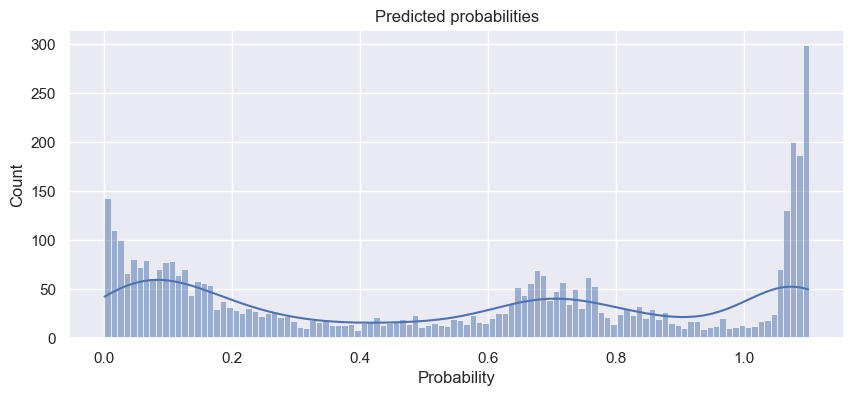

In [228]:
plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

In [246]:
print(np.round(100*np.round(preds).sum()/len(preds),2))

54.59


In [261]:
preds_tuned=(preds>=0.4).astype(int)

In [262]:
sub = pd.read_csv('/spaceship-titanic/test.csv')

sub['Transported']=preds_tuned.astype(int)
sub['Transported'] = sub.Transported.replace({0:False, 1:True})

sub[['PassengerId', 'Transported']].to_csv('submission.csv', index=False)

In [255]:
sub[['PassengerId', 'Transported']]

PassengerId  Transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01         True
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]